# FE630 Portfolio Theory & Applications - Napat L.
# Final Project: Building and Backtesting a Long-Short Global Macro Portfolio with a Target Beta 

The purpose of this project is to implement portfolio optimization on Long/Short Global Macro Strategy based on a factor-based model with Beta Target to evaluate the sensitivity of strategy in variations of Beta.

# 1. Data preparation, Class and Method

## 1.1 Data source

We download data from Yahoo Finance and Fama French data from Wharton Research Data Services (wrds).

In [1]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override()
from pandas_datareader.famafrench import get_available_datasets
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

## 1.2 Investment Universe

We consider 13 ETFs from 01/01/2007 to 10/20/2016 which we download from Yahoo Finance as follows:
1. Currency Shares Euro Trist (FXE)
2. iShares MSCI Japan Index (EWJ)
3. SPDR GOLD Trust (GLD)
4. Powershares NASDAQ-100 Trust (QQQ)
5. SPDR S&P 500 (SPY)
6. iShares Lehman Short Treasury Bond (SHV)
7. PowerShares DB Agriculture Fund (DBA)
8. United States Oil Fund LP (USO)
9. SPDR S&P Biotech (XBI)
10. iShares S&P Latin America 40 Index (ILF)
11. SPDR S&P Emerging Middle Est & Africa (GAF)
12. iShares S&P Pacific ex-Japan Index Fund (EPP)
13. SPDR DJ Euro Stoxx 50 (FEZ)


In [2]:
markets = ['FXE', 'EWJ', 'GLD', 'QQQ', 'SPY', 'SHV', 'DBA', 'USO', 'XBI', 'ILF', 'GAF', 'EPP', 'FEZ']

market_data = pdr.get_data_yahoo(markets, start="2007-01-01", end="2016-10-20")

market_ret = market_data.ix['Close', :, :].dropna()
market_ret = market_ret.pct_change()

fama = pd.read_csv('4542f455888a6b40.csv', index_col='date', parse_dates=True)

df_market = pd.concat([market_ret, fama], axis=1, join='inner')
df_market = df_market.dropna()

R = df_market.ix[:,0:13]
ff = df_market.ix[:,13:(df_market.shape[1]-1)]

[*********************100%***********************]  13 of 13 downloaded


# 1.3 Investment Strategy

## 1.3.1 Overview
We will consider an portfolio optimization problem of the form:

\begin{equation*} 
\begin{aligned}
& \underset{w \in \mathbb{R}^n}{\text{maximize}}
& & \rho^Tw - \lambda(w - w_{previous})^T Q (w - w_{previous})  \\
& \text{subject to}
& & \sum_{i=1}^{n}\beta_i^mw_i = \beta_{Target}^m \\
& & & \sum_{i=1}^{n} w_i = 1, -2 \leq w_i \leq 2
\end{aligned}
\tag{1.1}\label{opt-1}
\end{equation*}

Portfolio's Target Beta:
 \begin{aligned} $\beta_{Target}^m = 0.5, 1.0, 1.5$  \end{aligned} 

The return of a security is given by the formula of The Fama French 3-factor model:
 $ r_i = r_f + \beta^3_i(r_M - r_f) + b^s_i r_{SMB} + b^v_ir_{HML} + \alpha_i + \varepsilon_i$  

$\mathbb{E}(\varepsilon_i) = 0$ in such a way that we have in terms of Expected Return:
 $\rho_i = \rho_f + \beta^3_i(\rho_M - r_f) + b^s_i \rho_{SMB} + b^v_i\rho_{HML} + \alpha_i$  

$\beta_i^m = \frac{cov(r_i, r_{Brenchmark})}{\sigma^2(r_{Brenchmark})}$ is the Beta of security $S_i$ as defined in the CAPM Model so that $\beta^m_P = \sum_{i=1}^{n}\beta_i^mw_i$ is the Beta of the Portfolio.


$\lambda$ is a small regularization, 
$Q$ is the Indentity matrix or alternatively $Q = \Sigma$ in which $\Sigma$ is covariance matrix of security return given by Fama French 3-factor model

## 1.3.2 Model

We use Fama-French 3-factor  model to calculate the vector of return, $\rho$ with different portfolio's target Beta, $\beta_{T_1}^m$ = 0.5, $\beta_{T_2}^m$ = 1 and $\beta_{T_2}^m$ = 1.5 to measure behavior of risk relative to the market. We download the factor data from Wharton Research Data Services (wrds). The factors are recalculated depending on selected time periods as below:


- Short term (ST) model:	50 days
- Long term (LT) model:	200 days


In [ ]:
def optimization_strategy(self, wp, rho, lamda, Q, beta_market, beta_target):
    from scipy.optimize import minimize
    def fun_strategy(w, wp, rho, lamda, Q):
        return (-w).dot(rho)+lamda*(w-wp).dot(Q.dot((w-wp).T))
    
    cons=({'type':'eq','fun':lambda w: (w).dot(beta_market)-beta_target}, 
        {'type':'eq','fun':lambda w: sum(w)-1})
    
    return minimize(fun_strategy, 13*[1/13], args=(wp, rho, lamda, Q), constraints=cons,bounds=[[-2,2]]*13)

def cal_beta_market(self, R_vec, Rm, N = 13):
        import numpy as np
        beta = []
        for i in range(0,N):
            sol = np.cov(R_vec.ix[:,i], R_vec.ix[:, Rm.upper()])/np.var(R_vec.ix[:, Rm.upper()])
            beta.append(sol[0,1])
        
        return np.array(beta)

## 1.4 Benchmark

There are 2 benchmarks which we use
1. The Market Portfolio (S&P 500)
2. The Mean-Variance Long/Short Portfolio with yearly return target of 15%, holdings between -2 and +2.

\begin{equation*} 
\begin{aligned}
& \underset{w \in \mathbb{R}^n}{\text{maximize}}
& & w^T \Sigma w - \lambda(w - w_{previous})^T Q (w - w_{previous})  \\
& \text{subject to}
& & \sum_{i=1}^{n}\rho^T w = 15\% \\
& & & \sum_{i=1}^{n} w_i = 1, -2 \leq w_i \leq 2
\end{aligned}
\tag{1.1}\label{opt-1}
\end{equation*}

In [ ]:
def optimization_minvar(self, wp, rho, lamda, Q, sigma):
    from scipy.optimize import minimize
    def fun_minvar(w, wp, rho, lamda, Q, sigma):
        return (w).dot(sigma.dot(w.T))+lamda*(w-wp).dot(Q.dot((w-wp).T))
    
    cons=({'type':'eq','fun':lambda w: w.dot(rho)-15/100/252}, 
        {'type':'eq','fun':lambda w: sum(w)-1})
    
    return minimize(fun_minvar, 13*[1/13], args=(wp, rho, lamda, Q, sigma), constraints=cons,bounds=[[-2,2]]*13)

# 1.5 Risk Indicator

Our models will be assessed based on key indicators as below:
- Cumulated PnL or Return
- Daily Mean Geometric Return
- Daily Min Return
- Max 10 days Drawndown
- Volatility
- Sharpe Ratio
- Skewness
- Kurtosis
- Modified VaR
- CVaR

In [ ]:
def risk_indicator(self, perf = None):
        import numpy as np
        from scipy import stats
        import pandas as pd
        
        if perf is not None:
            perf = perf
        else:
            perf = self.performance

        annual_ret = perf.add(1).prod()** (252 / len(perf)) - 1
        mean_ret = np.mean(perf, axis=0)
        min_ret = np.min(perf, axis=0)
        volatility = np.std(perf, axis=0)
        sharpe = mean_ret/volatility
        skewness = stats.skew(perf, axis=0)
        kurtosis = stats.kurtosis(perf, axis=0)
    
        Roll_10Max = pd.rolling_max(perf.add(1).cumprod().subtract(1), 10, min_periods=1)
        day10_Drawdown = perf.add(1).cumprod().subtract(1).div(Roll_10Max) - 1
        Max_10day_Drawdown = pd.rolling_min(day10_Drawdown, 10, min_periods=1)
        max_10dd = Max_10day_Drawdown.min()
    
        VaR_list = []
        for i in perf.columns:
            VaR_list.append(np.percentile(perf.ix[:,i], .01))
    
        CVaR_list = []
        for i in perf.columns:
            CVaR_list.append(np.mean(np.sort(perf.ix[:,i].values)[np.sort(perf.ix[:,i].values) <= np.percentile(perf.ix[:,i], .01)]))
        
        
        if perf is not None:
            result = pd.DataFrame(columns=perf.columns)
        else:
            result = pd.DataFrame(columns=['Beta=0.5', 'Beta=1.0', 'Beta=1.5', 'MinVar', self.benchmark])
        
        result.loc['Annual.Return'] = annual_ret
        result.loc['Daily.Mean'] = mean_ret
        result.loc['Daily.Min'] = min_ret
        result.loc['Max10.DD'] = max_10dd
        result.loc['Volatility'] = volatility
        result.loc['Sharpe.Ratio'] = sharpe
        result.loc['Skewness'] = skewness 
        result.loc['Kurtosis'] = kurtosis
        result.loc['Mod.VaR'] = VaR_list
        result.loc['CVaR'] = CVaR_list
        
        return result

# 1.6 Backtesting

We split time period for backtesting into 3 periods of time, Before Sub-prime crisis, During Sub-prime Crisis and After Sub-prime Crisis. The detail is as below:


- Before Sub-prime Crisis: March 19, 2007 - January 31, 2008 
- During Sub-prime Crisis: February 2, 2008 - June 01, 2009 
- Before Sub-prime Crisis: June 02, 2009 - October 20, 2016 

In [3]:
from datetime import datetime

bc_return = R[R.index <= datetime.strptime("2008-01-31", '%Y-%m-%d')]
dc_return = R[(R.index >= datetime.strptime("2008-02-01", '%Y-%m-%d')) & (R.index <= datetime.strptime("2009-06-01", '%Y-%m-%d'))]
ac_return = R[R.index >= datetime.strptime("2009-06-02", '%Y-%m-%d')]

bc_fama = ff[ff.index <= datetime.strptime("2008-01-31", '%Y-%m-%d')]
dc_fama = ff[(ff.index >= datetime.strptime("2008-02-01", '%Y-%m-%d')) & (R.index <= datetime.strptime("2009-06-01", '%Y-%m-%d'))]
ac_fama = ff[ff.index >= datetime.strptime("2009-06-02", '%Y-%m-%d')]

# 1.7 Strategy Performance Class Object

In [4]:
class portfolio_startegy:
    
    def __init__(self, data_market, data_fama, term, Q_ident = False, lamda=1/2, benchmark = 'SPY'):
        self.data_market = data_market
        self.data_fama = data_fama
        self.term = term
        self.lamda = lamda
        self.Q_ident = Q_ident
        self.benchmark = benchmark
        self.performance = None
        self.weight_b1 = pd.DataFrame(columns=data_market.columns)
        self.weight_b2 = pd.DataFrame(columns=data_market.columns)
        self.weight_b3 = pd.DataFrame(columns=data_market.columns)
        
    def cal_beta_market(self, R_vec, Rm, N = 13):
        import numpy as np
        beta = []
        for i in range(0,N):
            sol = np.cov(R_vec.ix[:,i], R_vec.ix[:, Rm.upper()])/np.var(R_vec.ix[:, Rm.upper()])
            beta.append(sol[0,1])
        
        return np.array(beta)
    
    def optimization_strategy(self, wp, rho, lamda, Q, beta_market, beta_target):
        from scipy.optimize import minimize
        def fun_strategy(w, wp, rho, lamda, Q):
            return (-w).dot(rho)+lamda*(w-wp).dot(Q.dot((w-wp).T))
    
        cons=({'type':'eq','fun':lambda w: (w).dot(beta_market)-beta_target}, 
               {'type':'eq','fun':lambda w: sum(w)-1})
    
        return minimize(fun_strategy, 13*[1/13], args=(wp, rho, lamda, Q), constraints=cons,bounds=[[-2,2]]*13)

    def optimization_minvar(self, wp, rho, lamda, Q, sigma):
        from scipy.optimize import minimize
        def fun_minvar(w, wp, rho, lamda, Q, sigma):
            return (w).dot(sigma.dot(w.T))+lamda*(w-wp).dot(Q.dot((w-wp).T))
    
        cons=({'type':'eq','fun':lambda w: w.dot(rho)-15/100/252}, 
                {'type':'eq','fun':lambda w: sum(w)-1})
    
        return minimize(fun_minvar, 13*[1/13], args=(wp, rho, lamda, Q, sigma), constraints=cons,bounds=[[-2,2]]*13)
    
    def strategy_performace(self):
        import numpy as np
        import statsmodels.api as sm
        import pandas as pd
        
        mkt_ret, fama_ret, term, lamda, benchmark = self.data_market, self.data_fama, self.term, self.lamda, self.benchmark
        
        wp1 = np.zeros(13)
        wp2 = np.zeros(13)
        wp3 = np.zeros(13)
        wp_minvar = np.zeros(13)
        check_loop = 0
    
        for i in range (term,len(mkt_ret)):
            if i%term==0:
    
                beta_fama = sm.OLS(mkt_ret[(i-term):i].subtract(fama_ret['rf'][(i-term):i] ,axis=0), sm.add_constant(fama_ret[['mktrf','smb','hml']][(i-term):i])).fit().params.values
                ri = (sm.add_constant(fama_ret[['mktrf','smb','hml']][(i-term):i]).dot(beta_fama)).add(fama_ret['rf'][(i-term):i], axis=0)
                rho = ri.mean()
                beta_market = self.cal_beta_market(mkt_ret[(i-term):i], Rm=benchmark)
            
                sigma = ri.cov() 
                
                Q = np.where(self.Q_ident == False, sigma, np.diag((13*[1])))
            
                solution1 = self.optimization_strategy(wp1, rho, lamda, Q, beta_market, beta_target = 0.5)
                wp1 = solution1.x
                self.weight_b1.loc[i] = wp1
            
                solution2 = self.optimization_strategy(wp2, rho, lamda, Q, beta_market, beta_target = 1.0)
                wp2 = solution2.x
                self.weight_b2.loc[i] = wp2
            
                solution3 = self.optimization_strategy(wp3, rho, lamda, Q, beta_market, beta_target = 1.5)
                wp3 = solution3.x
                self.weight_b3.loc[i] = wp3
            
                solution_minvar = self.optimization_minvar(wp_minvar, rho, lamda, Q, sigma)
                wp_minvar = solution_minvar.x
            
                if check_loop == 0:
                    return_strategy1 = mkt_ret[(i-term):i].dot(wp1)
                    return_strategy2 = mkt_ret[(i-term):i].dot(wp2)
                    return_strategy3 = mkt_ret[(i-term):i].dot(wp3)
                    return_strategy_minvar = mkt_ret[(i-term):i].dot(wp_minvar)
                    return_benchmark = mkt_ret[(i-term):i][benchmark]
                else:
                    return_strategy1 = pd.concat([return_strategy1, mkt_ret[(i-term):i].dot(wp1)], axis=0)
                    return_strategy2 = pd.concat([return_strategy2, mkt_ret[(i-term):i].dot(wp2)], axis=0)
                    return_strategy3 = pd.concat([return_strategy3, mkt_ret[(i-term):i].dot(wp3)], axis=0)
                    return_strategy_minvar = pd.concat([return_strategy_minvar, mkt_ret[(i-term):i].dot(wp_minvar)], axis=0)
                    return_benchmark = pd.concat([return_benchmark, mkt_ret[(i-term):i][benchmark]], axis=0)
                check_loop += 1
    
        performance = pd.DataFrame({'Beta=0.5':return_strategy1,
                        'Beta=1.0':return_strategy2,
                        'Beta=1.5':return_strategy3,
                        'MinVar':return_strategy_minvar,
                        benchmark:return_benchmark})
        self.performance = performance
        self.return_strategy1 = return_strategy1
        self.return_strategy2 = return_strategy2
        self.return_strategy3 = return_strategy3
        self.underlying_analytics()
        return performance
    
    def performance_plot(self):
        import matplotlib.pyplot as plt
        from matplotlib import style
        import matplotlib.dates as mdates
        
        if self.performance is None:
            self.strategy_performace()
        perf = self.performance
    
        term, benchmark = self.term, self.benchmark
    
        style.use('ggplot')
        fig = plt.figure(figsize=(15, 10))
        fig.suptitle('Portfolio Strategy Performance', fontsize=18, fontweight='bold')
    
        ax1 = plt.subplot2grid((15, 10), (0, 0), rowspan=10, colspan=15)
        ax1.plot(perf['Beta=0.5'].add(1).cumprod().subtract(1), c='orange',  label = "Beta=0.5 {0} terms, Cumulative return = {1:0.4f}".format(term, perf.add(1).cumprod().subtract(1).ix[-1, 'Beta=0.5']))
        ax1.annotate("{0}: {1:0.4f}".format('Beta=0.5', perf.add(1).cumprod().subtract(1).ix[-1, 'Beta=0.5']), xy=(1, perf.add(1).cumprod().subtract(1).ix[-1, 'Beta=0.5']), xytext=(8, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
            
        ax1.plot(perf['Beta=1.0'].add(1).cumprod().subtract(1), c='dodgerblue', label = "Beta=1.0 {0} terms, Cumulative return = {1:0.4f}".format(term, perf.add(1).cumprod().subtract(1).ix[-1, 'Beta=1.0']))
        ax1.annotate("{0}: {1:0.4f}".format('Beta=1.0', perf.add(1).cumprod().subtract(1).ix[-1, 'Beta=1.0']), xy=(1, perf.add(1).cumprod().subtract(1).ix[-1, 'Beta=1.0']), xytext=(8, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
    
        ax1.plot(perf['Beta=1.5'].add(1).cumprod().subtract(1), c='limegreen', label = "Beta=1.5 {0} terms, Cumulative return = {1:0.4f}".format(term, perf.add(1).cumprod().subtract(1).ix[-1, 'Beta=1.5']))
        ax1.annotate("{0}: {1:0.4f}".format('Beta=1.5', perf.add(1).cumprod().subtract(1).ix[-1, 'Beta=1.5']), xy=(1, perf.add(1).cumprod().subtract(1).ix[-1, 'Beta=1.5']), xytext=(8, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
    
        ax1.plot(perf['MinVar'].add(1).cumprod().subtract(1), c='magenta', label = "MinVar {0} terms, Cumulative return = {1:0.4f}".format(term, perf.add(1).cumprod().subtract(1).ix[-1, 'MinVar']))
        ax1.annotate("{0}: {1:0.4f}".format('MinVar', perf.add(1).cumprod().subtract(1).ix[-1, 'MinVar']), xy=(1, perf.add(1).cumprod().subtract(1).ix[-1, 'MinVar']), xytext=(8, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
    
        ax1.plot(perf[benchmark].add(1).cumprod().subtract(1), c='black', label = "{0} {1} terms, Cumulative return = {2:0.4f}".format(benchmark, term, perf.add(1).cumprod().subtract(1).ix[-1, benchmark]))
        ax1.annotate("{0}: {1:0.4f}".format(benchmark, perf.add(1).cumprod().subtract(1).ix[-1, benchmark]), xy=(1, perf.add(1).cumprod().subtract(1).ix[-1, benchmark]), xytext=(8, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
    
        ax1.set_title('{0}-terms factor model with \n Min-variance strategy and {1} benchmark \n The best strategy is {2} with {3:0.4f} return'.format(term, benchmark,perf.add(1).cumprod().subtract(1).ix[-1,:].index[perf.add(1).cumprod().subtract(1).ix[-1,:] == perf.add(1).cumprod().subtract(1).ix[-1,:].max()].tolist()[0], perf.add(1).cumprod().subtract(1).ix[-1,:].max()))
        ax1.legend()
    
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M:%S'))
        ax1.set_ylabel('Return')
        plt.xticks(rotation=45)
        plt.xlabel('Date Hours:Minutes')
        plt.plot()
    
    def risk_indicator(self, perf = None):
        import numpy as np
        from scipy import stats
        import pandas as pd
        
        if perf is not None:
            perf = perf
        else:
            perf = self.performance

        annual_ret = perf.add(1).prod()** (252 / len(perf)) - 1
        mean_ret = np.mean(perf, axis=0)
        min_ret = np.min(perf, axis=0)
        volatility = np.std(perf, axis=0)
        sharpe = mean_ret/volatility
        skewness = stats.skew(perf, axis=0)
        kurtosis = stats.kurtosis(perf, axis=0)
    
        Roll_10Max = pd.rolling_max(perf.add(1).cumprod().subtract(1), 10, min_periods=1)
        day10_Drawdown = perf.add(1).cumprod().subtract(1).div(Roll_10Max) - 1
        Max_10day_Drawdown = pd.rolling_min(day10_Drawdown, 10, min_periods=1)
        max_10dd = Max_10day_Drawdown.min()
    
        VaR_list = []
        for i in perf.columns:
            VaR_list.append(np.percentile(perf.ix[:,i], .01))
    
        CVaR_list = []
        for i in perf.columns:
            CVaR_list.append(np.mean(np.sort(perf.ix[:,i].values)[np.sort(perf.ix[:,i].values) <= np.percentile(perf.ix[:,i], .01)]))
        
        
        if perf is not None:
            result = pd.DataFrame(columns=perf.columns)
        else:
            result = pd.DataFrame(columns=['Beta=0.5', 'Beta=1.0', 'Beta=1.5', 'MinVar', self.benchmark])
        
        result.loc['Annual.Return'] = annual_ret
        result.loc['Daily.Mean'] = mean_ret
        result.loc['Daily.Min'] = min_ret
        result.loc['Max10.DD'] = max_10dd
        result.loc['Volatility'] = volatility
        result.loc['Sharpe.Ratio'] = sharpe
        result.loc['Skewness'] = skewness 
        result.loc['Kurtosis'] = kurtosis
        result.loc['Mod.VaR'] = VaR_list
        result.loc['CVaR'] = CVaR_list
        
        return result
    
    def underlying_analytics(self):
        import pandas as pd
        
        mkt_data = self.data_market.ix[0:len(self.return_strategy1),:]
        
        underly1 = pd.concat([mkt_data, self.return_strategy1.rename('Beta=0.5')], axis=1)
        self.underly1 = self.risk_indicator(underly1)
        
        underly2 = pd.concat([mkt_data, self.return_strategy2.rename('Beta=1.0')], axis=1)
        self.underly2 = self.risk_indicator(underly2)
        
        underly3 = pd.concat([mkt_data, self.return_strategy3.rename('Beta=1.5')], axis=1)
        self.underly3 = self.risk_indicator(underly3)


# 2. Strategy Performance

# 2.1 Before Sub-prime crisis

## 2.1.1 Before Sub-prime crisis Short-term model

In [5]:
port_bc_short = portfolio_startegy(data_market = bc_return, data_fama = bc_fama, term = 50)

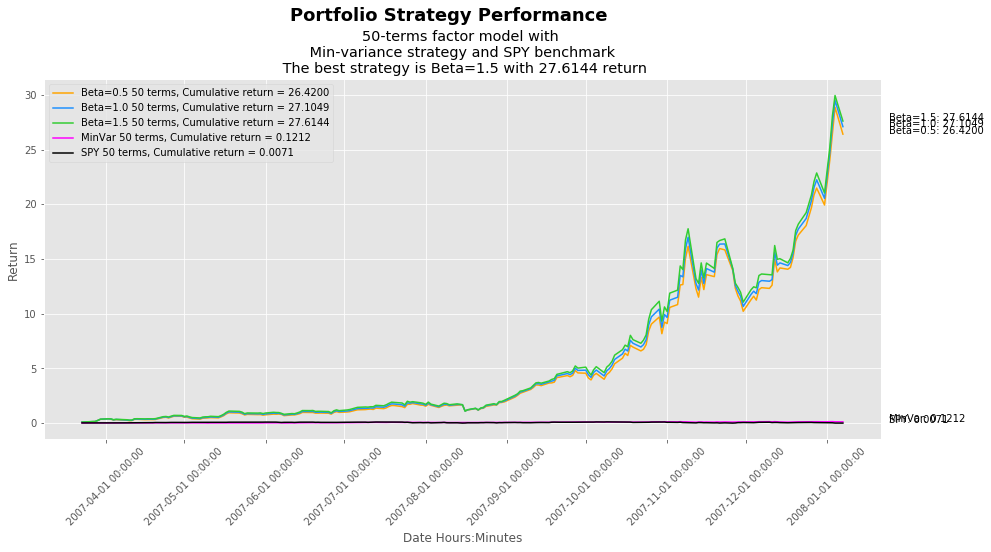

In [7]:
port_bc_short.performance_plot()

## 2.1.2 Before Sub-prime crisis Short term Risk Indicator

In [8]:
port_bc_short.risk_indicator()

,Beta=0.5,Beta=1.0,Beta=1.5,MinVar,SPY
Annual.Return,63.858077,65.905988,67.438045,0.155008,0.008905
Daily.Mean,0.018595,0.018774,0.018953,0.000595,0.000091
Daily.Min,-0.226010,-0.234231,-0.242301,-0.022794,-0.029634
Max10.DD,-0.415839,-0.371481,-0.396507,-0.592767,-0.912773
Volatility,0.061681,0.062501,0.063833,0.006814,0.010546
Sharpe.Ratio,0.301471,0.300373,0.296907,0.087351,0.008619
Skewness,-0.231836,-0.248583,-0.274053,-0.153216,-0.262178
Kurtosis,1.740350,1.856566,1.906249,0.650561,0.830645
Mod.VaR,-0.225713,-0.233842,-0.241824,-0.022657,-0.029590
CVaR,-0.226010,-0.234231,-0.242301,-0.022794,-0.029634


## 2.1.3 Before Sub-prime crisis Short term Underlyings Analytics 

### 2.1.3.1 Beta = 0.5

In [9]:
port_bc_short.underly1

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=0.5
Annual.Return,0.409079,0.207598,-1.455541e-01,0.198710,0.133681,0.230664,0.404454,0.524845,0.144730,0.007052,0.008905,0.737507,0.364315,63.858077
Daily.Mean,0.001440,0.000915,-5.742991e-04,0.000801,0.000506,0.000956,0.001407,0.001953,0.000610,0.000028,0.000091,0.002337,0.001298,0.018595
Daily.Min,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.226010
Max10.DD,-42.000000,-1.094241,-7.006281e+13,-0.747253,-1.039410,-1.022569,-2.513502,-0.769346,-0.757281,-1.333335,-0.912773,-1.293108,-0.504213,-0.415839
Volatility,0.012527,0.018218,9.964352e-03,0.012783,0.004099,0.016250,0.010777,0.023549,0.012095,0.000839,0.010546,0.016934,0.011406,0.061681
Sharpe.Ratio,0.114986,0.050247,-5.763536e-02,0.062671,0.123553,0.058859,0.130550,0.082933,0.050422,0.033660,0.008619,0.138034,0.113840,0.301471
Skewness,-0.381747,-0.346097,-1.208419e-01,0.012245,-0.362669,-0.367793,-0.442185,-0.098105,-0.366348,-3.188987,-0.262178,0.173241,0.124612,-0.231836
Kurtosis,0.423128,0.217823,7.429437e-01,0.416810,0.248990,0.296316,1.630690,0.710361,0.999615,11.128372,0.830645,0.056944,0.196406,1.740350
Mod.VaR,-0.039131,-0.049405,-3.886123e-02,-0.032715,-0.013656,-0.049860,-0.046851,-0.069644,-0.043649,-0.004278,-0.029590,-0.040805,-0.027760,-0.225713
CVaR,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.226010


The rebalancing of Weights for beta = 0.5 during the iteration.

In [10]:
port_bc_short.weight_b1

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI
50,-2.00000,-1.267740,-2.0,1.664796,1.959894,-2.000000,-2.000000,2.000000,-0.628706,1.311987,0.433666,1.526103,2.000000
100,-0.18369,0.740069,-2.0,-2.000000,-0.045945,0.046791,0.186059,0.178343,2.000000,-0.585667,-1.335959,2.000000,2.000000
150,1.44856,0.903445,-2.0,-2.000000,-0.031326,1.692313,2.000000,0.637913,-0.015405,-2.000000,-2.000000,2.000000,0.364500
200,2.00000,-2.000000,-2.0,1.469743,-0.344779,1.139107,2.000000,2.000000,-2.000000,-2.000000,-2.000000,2.000000,0.735929


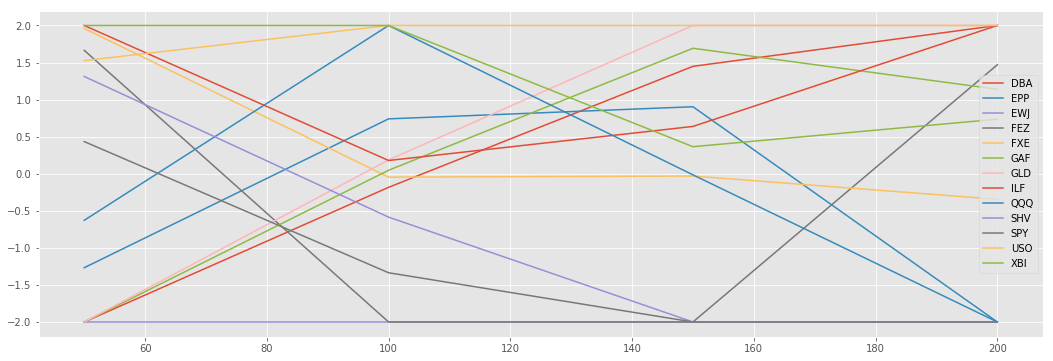

In [11]:
port_bc_short.weight_b1.plot(figsize=(18,6))

### 2.1.3.2 Beta = 1.0

In [12]:
port_bc_short.underly2

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.0
Annual.Return,0.409079,0.207598,-1.455541e-01,0.198710,0.133681,0.230664,0.404454,0.524845,0.144730,0.007052,0.008905,0.737507,0.364315,65.905988
Daily.Mean,0.001440,0.000915,-5.742991e-04,0.000801,0.000506,0.000956,0.001407,0.001953,0.000610,0.000028,0.000091,0.002337,0.001298,0.018774
Daily.Min,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.234231
Max10.DD,-42.000000,-1.094241,-7.006281e+13,-0.747253,-1.039410,-1.022569,-2.513502,-0.769346,-0.757281,-1.333335,-0.912773,-1.293108,-0.504213,-0.371481
Volatility,0.012527,0.018218,9.964352e-03,0.012783,0.004099,0.016250,0.010777,0.023549,0.012095,0.000839,0.010546,0.016934,0.011406,0.062501
Sharpe.Ratio,0.114986,0.050247,-5.763536e-02,0.062671,0.123553,0.058859,0.130550,0.082933,0.050422,0.033660,0.008619,0.138034,0.113840,0.300373
Skewness,-0.381747,-0.346097,-1.208419e-01,0.012245,-0.362669,-0.367793,-0.442185,-0.098105,-0.366348,-3.188987,-0.262178,0.173241,0.124612,-0.248583
Kurtosis,0.423128,0.217823,7.429437e-01,0.416810,0.248990,0.296316,1.630690,0.710361,0.999615,11.128372,0.830645,0.056944,0.196406,1.856566
Mod.VaR,-0.039131,-0.049405,-3.886123e-02,-0.032715,-0.013656,-0.049860,-0.046851,-0.069644,-0.043649,-0.004278,-0.029590,-0.040805,-0.027760,-0.233842
CVaR,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.234231


The rebalancing of Weights for beta = 1.0 during the iteration.

In [13]:
port_bc_short.weight_b2

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI
50,-2.000000,-1.117318,-2.0,1.785336,1.798440,-2.000000,-2.000000,2.000000,-0.550332,1.153060,0.486953,1.443862,2.000000
100,-0.299640,0.816179,-2.0,-2.000000,-0.143330,0.129135,0.117222,0.327383,2.000000,-0.687763,-1.259185,2.000000,2.000000
150,1.288833,0.988693,-2.0,-2.000000,-0.117324,1.653342,2.000000,0.813609,0.030849,-2.000000,-2.000000,2.000000,0.341998
200,2.000000,-2.000000,-2.0,1.603321,-0.754997,1.430668,2.000000,2.000000,-2.000000,-2.000000,-2.000000,2.000000,0.721008


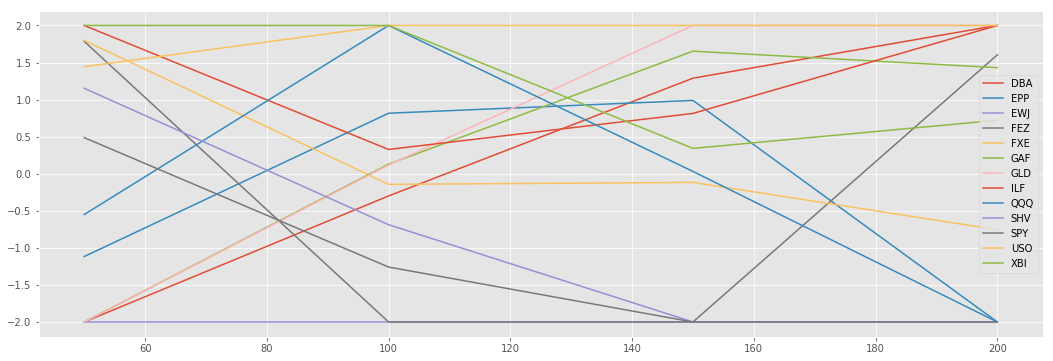

In [14]:
port_bc_short.weight_b2.plot(figsize=(18,6))

### 2.1.3.3 Beta = 1.5

In [15]:
port_bc_short.underly3

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.5
Annual.Return,0.409079,0.207598,-1.455541e-01,0.198710,0.133681,0.230664,0.404454,0.524845,0.144730,0.007052,0.008905,0.737507,0.364315,67.438045
Daily.Mean,0.001440,0.000915,-5.742991e-04,0.000801,0.000506,0.000956,0.001407,0.001953,0.000610,0.000028,0.000091,0.002337,0.001298,0.018953
Daily.Min,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.242301
Max10.DD,-42.000000,-1.094241,-7.006281e+13,-0.747253,-1.039410,-1.022569,-2.513502,-0.769346,-0.757281,-1.333335,-0.912773,-1.293108,-0.504213,-0.396507
Volatility,0.012527,0.018218,9.964352e-03,0.012783,0.004099,0.016250,0.010777,0.023549,0.012095,0.000839,0.010546,0.016934,0.011406,0.063833
Sharpe.Ratio,0.114986,0.050247,-5.763536e-02,0.062671,0.123553,0.058859,0.130550,0.082933,0.050422,0.033660,0.008619,0.138034,0.113840,0.296907
Skewness,-0.381747,-0.346097,-1.208419e-01,0.012245,-0.362669,-0.367793,-0.442185,-0.098105,-0.366348,-3.188987,-0.262178,0.173241,0.124612,-0.274053
Kurtosis,0.423128,0.217823,7.429437e-01,0.416810,0.248990,0.296316,1.630690,0.710361,0.999615,11.128372,0.830645,0.056944,0.196406,1.906249
Mod.VaR,-0.039131,-0.049405,-3.886123e-02,-0.032715,-0.013656,-0.049860,-0.046851,-0.069644,-0.043649,-0.004278,-0.029590,-0.040805,-0.027760,-0.241824
CVaR,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.242301


The rebalancing of Weight changes for beta = 1.5 during the iteration.

In [16]:
port_bc_short.weight_b3

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI
50,-2.000000,-0.966573,-2.0,1.905374,1.637095,-2.000000,-2.000000,2.000000,-0.471428,0.994221,0.540009,1.361303,2.000000
100,-0.415479,0.892097,-2.0,-2.000000,-0.240744,0.211535,0.048263,0.476561,2.000000,-0.789798,-1.182435,2.000000,2.000000
150,1.128985,1.074215,-2.0,-2.000000,-0.202946,1.613629,2.000000,0.989377,0.077353,-2.000000,-2.000000,2.000000,0.319386
200,2.000000,-2.000000,-2.0,1.744897,-1.168103,1.715601,2.000000,2.000000,-2.000000,-2.000000,-2.000000,2.000000,0.707606


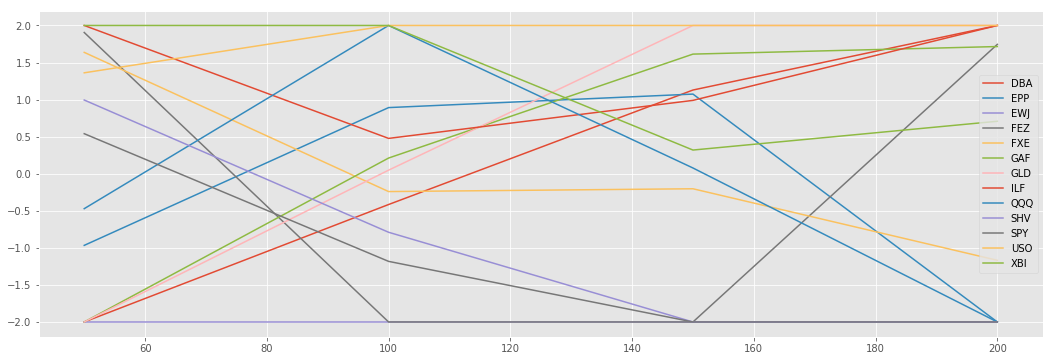

In [17]:
port_bc_short.weight_b3.plot(figsize=(18,6))

## 2.1.4 Before Sub-prime crisis Long-term model

In [18]:
port_bc_long = portfolio_startegy(data_market = bc_return, data_fama = bc_fama, term = 200)

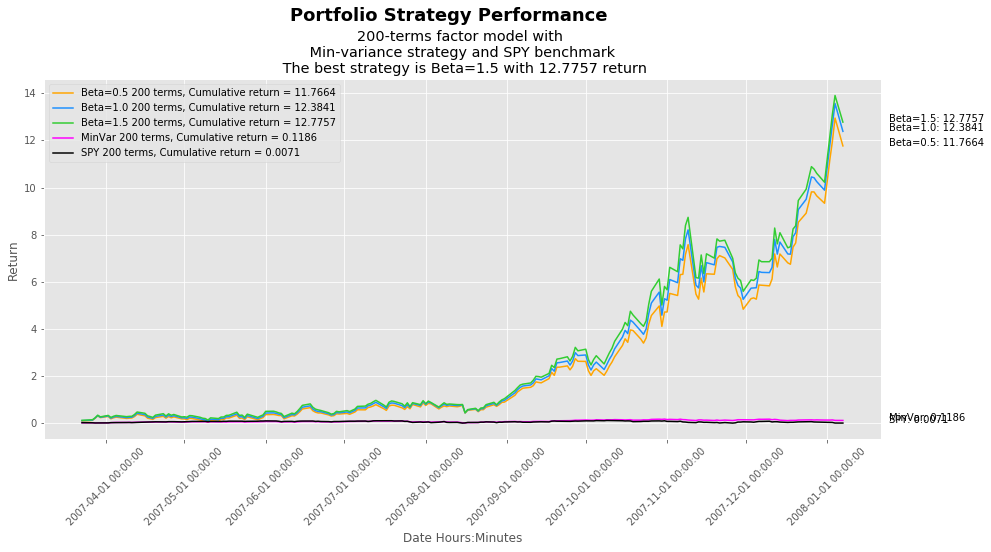

In [19]:
port_bc_long.performance_plot()

## 2.1.5 Before Sub-prime crisis Long term Risk Indicator

In [20]:
port_bc_long.risk_indicator()

,Beta=0.5,Beta=1.0,Beta=1.5,MinVar,SPY
Annual.Return,23.753936,25.272620,26.244719,0.151615,0.008905
Daily.Mean,0.015016,0.015336,0.015588,0.000595,0.000091
Daily.Min,-0.244762,-0.254635,-0.262677,-0.019788,-0.029634
Max10.DD,-0.836700,-0.727138,-0.637865,-0.804358,-0.912773
Volatility,0.066107,0.067289,0.068829,0.008352,0.010546
Sharpe.Ratio,0.227145,0.227911,0.226480,0.071267,0.008619
Skewness,-0.341433,-0.344749,-0.341159,-0.213110,-0.262178
Kurtosis,0.567725,0.631430,0.642454,0.017011,0.830645
Mod.VaR,-0.243608,-0.253379,-0.261350,-0.019775,-0.029590
CVaR,-0.244762,-0.254635,-0.262677,-0.019788,-0.029634


## 2.1.6 Before Sub-prime crisis Short term Underlyings Analytics 

### 2.1.6.1 Beta = 0.5

In [21]:
port_bc_long.underly1

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=0.5
Annual.Return,0.409079,0.207598,-1.455541e-01,0.198710,0.133681,0.230664,0.404454,0.524845,0.144730,0.007052,0.008905,0.737507,0.364315,23.753936
Daily.Mean,0.001440,0.000915,-5.742991e-04,0.000801,0.000506,0.000956,0.001407,0.001953,0.000610,0.000028,0.000091,0.002337,0.001298,0.015016
Daily.Min,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.244762
Max10.DD,-42.000000,-1.094241,-7.006281e+13,-0.747253,-1.039410,-1.022569,-2.513502,-0.769346,-0.757281,-1.333335,-0.912773,-1.293108,-0.504213,-0.836700
Volatility,0.012527,0.018218,9.964352e-03,0.012783,0.004099,0.016250,0.010777,0.023549,0.012095,0.000839,0.010546,0.016934,0.011406,0.066107
Sharpe.Ratio,0.114986,0.050247,-5.763536e-02,0.062671,0.123553,0.058859,0.130550,0.082933,0.050422,0.033660,0.008619,0.138034,0.113840,0.227145
Skewness,-0.381747,-0.346097,-1.208419e-01,0.012245,-0.362669,-0.367793,-0.442185,-0.098105,-0.366348,-3.188987,-0.262178,0.173241,0.124612,-0.341433
Kurtosis,0.423128,0.217823,7.429437e-01,0.416810,0.248990,0.296316,1.630690,0.710361,0.999615,11.128372,0.830645,0.056944,0.196406,0.567725
Mod.VaR,-0.039131,-0.049405,-3.886123e-02,-0.032715,-0.013656,-0.049860,-0.046851,-0.069644,-0.043649,-0.004278,-0.029590,-0.040805,-0.027760,-0.243608
CVaR,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.244762


The rebalancing of Weights for beta = 0.5 during the iteration.

In [22]:
port_bc_long.weight_b1

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI
200,2.0,-0.462243,-2.0,-0.45164,-0.412844,-0.169625,2.0,2.0,-0.977691,-1.739047,-2.0,2.0,1.21309


### 2.1.6.2 Beta = 1.0

In [23]:
port_bc_long.underly2

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.0
Annual.Return,0.409079,0.207598,-1.455541e-01,0.198710,0.133681,0.230664,0.404454,0.524845,0.144730,0.007052,0.008905,0.737507,0.364315,25.272620
Daily.Mean,0.001440,0.000915,-5.742991e-04,0.000801,0.000506,0.000956,0.001407,0.001953,0.000610,0.000028,0.000091,0.002337,0.001298,0.015336
Daily.Min,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.254635
Max10.DD,-42.000000,-1.094241,-7.006281e+13,-0.747253,-1.039410,-1.022569,-2.513502,-0.769346,-0.757281,-1.333335,-0.912773,-1.293108,-0.504213,-0.727138
Volatility,0.012527,0.018218,9.964352e-03,0.012783,0.004099,0.016250,0.010777,0.023549,0.012095,0.000839,0.010546,0.016934,0.011406,0.067289
Sharpe.Ratio,0.114986,0.050247,-5.763536e-02,0.062671,0.123553,0.058859,0.130550,0.082933,0.050422,0.033660,0.008619,0.138034,0.113840,0.227911
Skewness,-0.381747,-0.346097,-1.208419e-01,0.012245,-0.362669,-0.367793,-0.442185,-0.098105,-0.366348,-3.188987,-0.262178,0.173241,0.124612,-0.344749
Kurtosis,0.423128,0.217823,7.429437e-01,0.416810,0.248990,0.296316,1.630690,0.710361,0.999615,11.128372,0.830645,0.056944,0.196406,0.631430
Mod.VaR,-0.039131,-0.049405,-3.886123e-02,-0.032715,-0.013656,-0.049860,-0.046851,-0.069644,-0.043649,-0.004278,-0.029590,-0.040805,-0.027760,-0.253379
CVaR,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.254635


The rebalancing of Weights for beta = 1.0 during the iteration.

In [24]:
port_bc_long.weight_b2

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI
200,2.0,-0.319477,-2.0,-0.387194,-0.584852,-0.049188,2.0,2.0,-0.963964,-1.991887,-2.0,2.0,1.296563


### 2.1.6.3 Beta = 1.5

In [25]:
port_bc_long.underly3

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.5
Annual.Return,0.409079,0.207598,-1.455541e-01,0.198710,0.133681,0.230664,0.404454,0.524845,0.144730,0.007052,0.008905,0.737507,0.364315,26.244719
Daily.Mean,0.001440,0.000915,-5.742991e-04,0.000801,0.000506,0.000956,0.001407,0.001953,0.000610,0.000028,0.000091,0.002337,0.001298,0.015588
Daily.Min,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.262677
Max10.DD,-42.000000,-1.094241,-7.006281e+13,-0.747253,-1.039410,-1.022569,-2.513502,-0.769346,-0.757281,-1.333335,-0.912773,-1.293108,-0.504213,-0.637865
Volatility,0.012527,0.018218,9.964352e-03,0.012783,0.004099,0.016250,0.010777,0.023549,0.012095,0.000839,0.010546,0.016934,0.011406,0.068829
Sharpe.Ratio,0.114986,0.050247,-5.763536e-02,0.062671,0.123553,0.058859,0.130550,0.082933,0.050422,0.033660,0.008619,0.138034,0.113840,0.226480
Skewness,-0.381747,-0.346097,-1.208419e-01,0.012245,-0.362669,-0.367793,-0.442185,-0.098105,-0.366348,-3.188987,-0.262178,0.173241,0.124612,-0.341159
Kurtosis,0.423128,0.217823,7.429437e-01,0.416810,0.248990,0.296316,1.630690,0.710361,0.999615,11.128372,0.830645,0.056944,0.196406,0.642454
Mod.VaR,-0.039131,-0.049405,-3.886123e-02,-0.032715,-0.013656,-0.049860,-0.046851,-0.069644,-0.043649,-0.004278,-0.029590,-0.040805,-0.027760,-0.261350
CVaR,-0.039182,-0.049494,-3.913043e-02,-0.032801,-0.013729,-0.049986,-0.047213,-0.069998,-0.043856,-0.004287,-0.029634,-0.040828,-0.027778,-0.262677


The rebalancing of Weights for beta = 1.5 during the iteration.

In [26]:
port_bc_long.weight_b3

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI
200,2.0,-0.13092,-2.0,-0.353222,-1.000925,0.103456,2.0,2.0,-1.042433,-2.0,-2.0,2.0,1.424044


# 2.2 During Sub-prime crisis

## 2.2.1 During Sub-prime crisis Short-term model

In [27]:
port_dc_short = portfolio_startegy(data_market = dc_return, data_fama = dc_fama, term = 50)

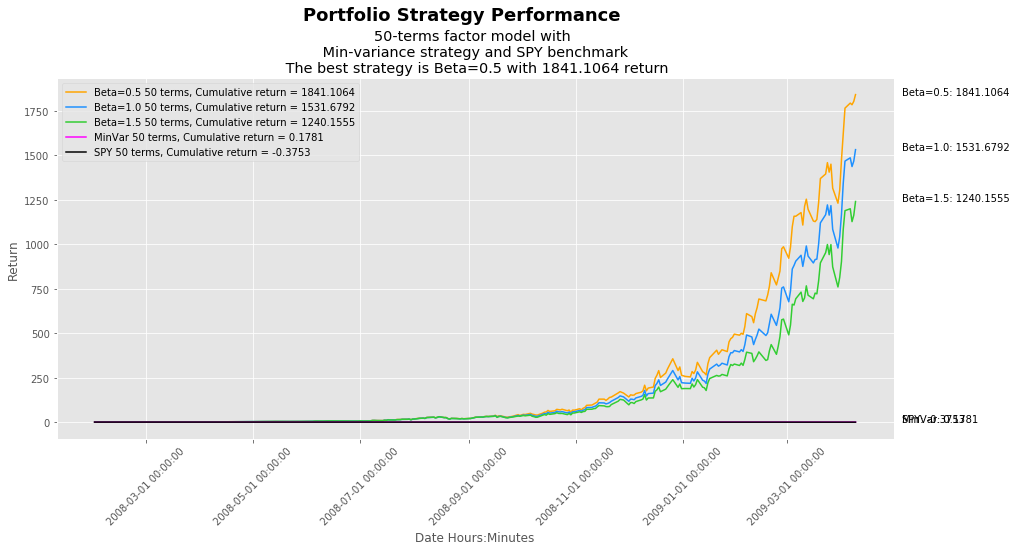

In [28]:
port_dc_short.performance_plot()

## 2.2.2 During Sub-prime crisis Risk Indicator

In [29]:
port_dc_short.risk_indicator()

,Beta=0.5,Beta=1.0,Beta=1.5,MinVar,SPY
Annual.Return,552.177302,473.000782,396.021473,0.147580,-0.326492
Daily.Mean,0.029178,0.028913,0.028800,0.000595,-0.001219
Daily.Min,-0.280082,-0.292929,-0.299917,-0.031417,-0.098448
Max10.DD,-1.885540,-1.793412,-1.857449,-4.720396,-10.464584
Volatility,0.087541,0.091561,0.098004,0.009889,0.026473
Sharpe.Ratio,0.333301,0.315777,0.293864,0.060194,-0.046035
Skewness,-0.137783,-0.131201,-0.086646,0.106946,0.500905
Kurtosis,0.731954,0.803214,0.950356,1.158753,4.858104
Mod.VaR,-0.278062,-0.290607,-0.298693,-0.031402,-0.098153
CVaR,-0.280082,-0.292929,-0.299917,-0.031417,-0.098448


## 2.2.3 During Sub-prime crisis Underlyings Analytics

### 2.2.3.1 Beta = 0.5

In [30]:
port_dc_short.underly1

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=0.5
Annual.Return,-0.280662,-0.378196,-0.288650,-0.417269,-0.099971,-0.281788,-0.046992,-0.330427,-0.232397,-0.001066,-0.326492,-0.513426,-0.146786,552.177302
Daily.Mean,-0.001043,-0.001290,-0.000965,-0.001603,-0.000370,-0.000710,0.000015,-0.000583,-0.000729,-0.000004,-0.001219,-0.002197,-0.000333,0.029178
Daily.Min,-0.086060,-0.112218,-0.104077,-0.114309,-0.030750,-0.136226,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.106846,-0.079870,-0.280082
Max10.DD,-6.000100,-4.900748,-7.909109,-30.001000,-11.083119,-10.489339,-22.121154,-3.926552,-8.261937,-17.010006,-10.464584,-93.714279,-36.071185,-1.885540
Volatility,0.022909,0.034563,0.027915,0.032930,0.009830,0.034711,0.020364,0.045014,0.025359,0.000602,0.026473,0.036217,0.024401,0.087541
Sharpe.Ratio,-0.045508,-0.037337,-0.034567,-0.048678,-0.037605,-0.020466,0.000756,-0.012953,-0.028740,-0.006731,-0.046035,-0.060674,-0.013666,0.333301
Skewness,-0.235849,0.512223,0.740479,0.609103,0.355459,0.198645,0.434655,0.457303,0.399126,-1.108524,0.500905,0.087545,0.411076,-0.137783
Kurtosis,0.930516,3.920646,4.995535,4.359820,1.316762,3.362091,3.556981,5.344111,3.022657,9.294882,4.858104,0.227851,2.870836,0.731954
Mod.VaR,-0.085686,-0.112093,-0.103553,-0.113850,-0.030599,-0.135641,-0.073818,-0.192985,-0.089252,-0.003585,-0.098153,-0.106814,-0.079549,-0.278062
CVaR,-0.086060,-0.112218,-0.104077,-0.114309,-0.030750,-0.136226,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.106846,-0.079870,-0.280082


The rebalancing of Weights for beta = 0.5 during the iteration.

In [31]:
port_dc_short.weight_b1

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI
50,2.0,-2.000000,-1.634935,2.000000,2.000000,1.745246,-1.730656,2.000000,-2.0,-1.403907,-2.000000,2.000000,0.024253
100,2.0,0.023400,0.825945,-2.000000,-1.950462,-2.000000,-2.000000,2.000000,2.0,-0.674721,-1.173355,2.000000,1.949193
150,-2.0,-2.000000,-2.000000,-2.000000,2.000000,1.271443,1.728557,-2.000000,2.0,2.000000,2.000000,-2.000000,2.000000
200,-2.0,-0.113867,2.000000,-0.070059,0.362741,0.258311,0.433931,0.369297,-2.0,2.000000,-0.240355,-2.000000,2.000000
250,2.0,-1.884986,0.568728,-2.000000,0.322690,0.675295,2.000000,2.000000,2.0,-2.000000,-0.763837,-2.000000,0.082109
300,-2.0,2.000000,-2.000000,-2.000000,0.023395,2.000000,1.377206,2.000000,2.0,0.636383,-2.000000,0.963016,-2.000000


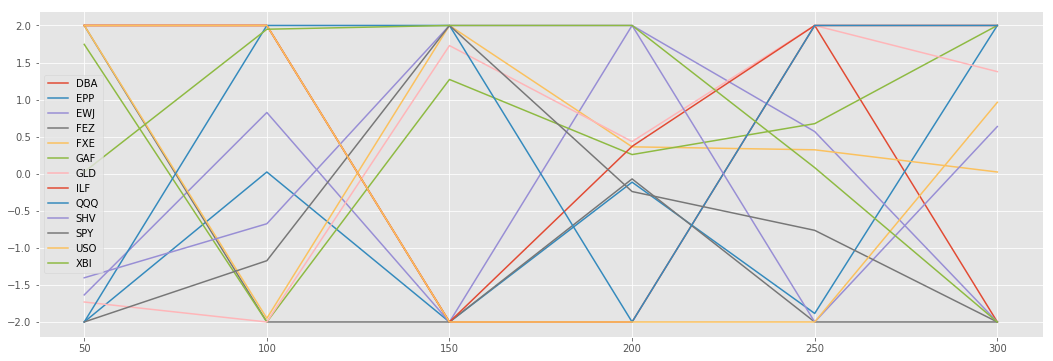

In [32]:
port_dc_short.weight_b1.plot(figsize=(18,6))

### 2.2.3.2 Beta = 1.0

In [33]:
port_dc_short.underly2

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.0
Annual.Return,-0.280662,-0.378196,-0.288650,-0.417269,-0.099971,-0.281788,-0.046992,-0.330427,-0.232397,-0.001066,-0.326492,-0.513426,-0.146786,473.000782
Daily.Mean,-0.001043,-0.001290,-0.000965,-0.001603,-0.000370,-0.000710,0.000015,-0.000583,-0.000729,-0.000004,-0.001219,-0.002197,-0.000333,0.028913
Daily.Min,-0.086060,-0.112218,-0.104077,-0.114309,-0.030750,-0.136226,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.106846,-0.079870,-0.292929
Max10.DD,-6.000100,-4.900748,-7.909109,-30.001000,-11.083119,-10.489339,-22.121154,-3.926552,-8.261937,-17.010006,-10.464584,-93.714279,-36.071185,-1.793412
Volatility,0.022909,0.034563,0.027915,0.032930,0.009830,0.034711,0.020364,0.045014,0.025359,0.000602,0.026473,0.036217,0.024401,0.091561
Sharpe.Ratio,-0.045508,-0.037337,-0.034567,-0.048678,-0.037605,-0.020466,0.000756,-0.012953,-0.028740,-0.006731,-0.046035,-0.060674,-0.013666,0.315777
Skewness,-0.235849,0.512223,0.740479,0.609103,0.355459,0.198645,0.434655,0.457303,0.399126,-1.108524,0.500905,0.087545,0.411076,-0.131201
Kurtosis,0.930516,3.920646,4.995535,4.359820,1.316762,3.362091,3.556981,5.344111,3.022657,9.294882,4.858104,0.227851,2.870836,0.803214
Mod.VaR,-0.085686,-0.112093,-0.103553,-0.113850,-0.030599,-0.135641,-0.073818,-0.192985,-0.089252,-0.003585,-0.098153,-0.106814,-0.079549,-0.290607
CVaR,-0.086060,-0.112218,-0.104077,-0.114309,-0.030750,-0.136226,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.106846,-0.079870,-0.292929


The rebalancing of Weights for beta = 1.0 during the iteration.

In [34]:
port_dc_short.weight_b2

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI
50,2.0,-2.000000,-1.632047,2.000000,2.000000,2.000000,-1.941534,2.000000,-1.979817,-1.572157,-2.000000,2.000000,0.125554
100,2.0,0.061552,0.648295,-2.000000,-1.992392,-1.332978,-2.000000,2.000000,2.000000,-0.997697,-0.748936,2.000000,1.362156
150,-2.0,-2.000000,-2.000000,-2.000000,1.980736,1.586878,1.432386,-2.000000,2.000000,2.000000,2.000000,-2.000000,2.000000
200,-2.0,-0.039941,2.000000,-0.024952,0.213511,0.326457,0.232190,0.517073,-2.000000,2.000000,-0.224338,-2.000000,2.000000
250,2.0,-1.665139,0.500040,-1.945625,-0.148206,0.839511,2.000000,2.000000,2.000000,-2.000000,-0.635883,-2.000000,0.055302
300,-2.0,2.000000,-2.000000,-2.000000,-0.002156,2.000000,1.063105,2.000000,2.000000,0.444281,-2.000000,1.494771,-2.000000


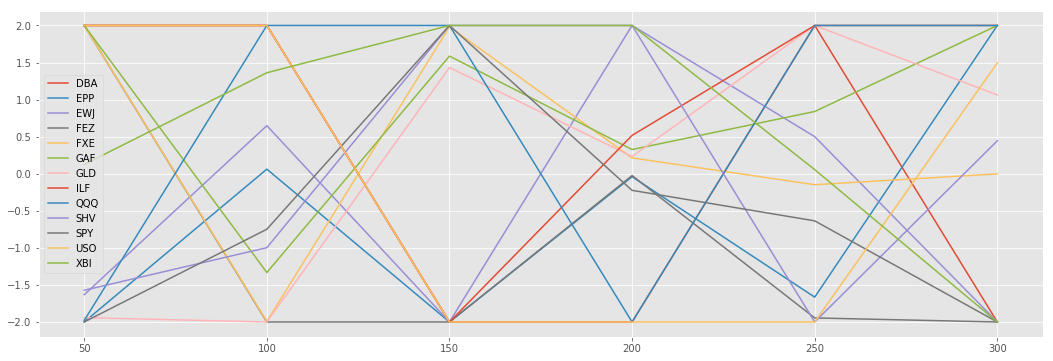

In [35]:
port_dc_short.weight_b2.plot(figsize=(18,6))

### 2.2.3.3 Beta = 1.5

In [36]:
port_dc_short.underly3

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.5
Annual.Return,-0.280662,-0.378196,-0.288650,-0.417269,-0.099971,-0.281788,-0.046992,-0.330427,-0.232397,-0.001066,-0.326492,-0.513426,-0.146786,396.021473
Daily.Mean,-0.001043,-0.001290,-0.000965,-0.001603,-0.000370,-0.000710,0.000015,-0.000583,-0.000729,-0.000004,-0.001219,-0.002197,-0.000333,0.028800
Daily.Min,-0.086060,-0.112218,-0.104077,-0.114309,-0.030750,-0.136226,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.106846,-0.079870,-0.299917
Max10.DD,-6.000100,-4.900748,-7.909109,-30.001000,-11.083119,-10.489339,-22.121154,-3.926552,-8.261937,-17.010006,-10.464584,-93.714279,-36.071185,-1.857449
Volatility,0.022909,0.034563,0.027915,0.032930,0.009830,0.034711,0.020364,0.045014,0.025359,0.000602,0.026473,0.036217,0.024401,0.098004
Sharpe.Ratio,-0.045508,-0.037337,-0.034567,-0.048678,-0.037605,-0.020466,0.000756,-0.012953,-0.028740,-0.006731,-0.046035,-0.060674,-0.013666,0.293864
Skewness,-0.235849,0.512223,0.740479,0.609103,0.355459,0.198645,0.434655,0.457303,0.399126,-1.108524,0.500905,0.087545,0.411076,-0.086646
Kurtosis,0.930516,3.920646,4.995535,4.359820,1.316762,3.362091,3.556981,5.344111,3.022657,9.294882,4.858104,0.227851,2.870836,0.950356
Mod.VaR,-0.085686,-0.112093,-0.103553,-0.113850,-0.030599,-0.135641,-0.073818,-0.192985,-0.089252,-0.003585,-0.098153,-0.106814,-0.079549,-0.298693
CVaR,-0.086060,-0.112218,-0.104077,-0.114309,-0.030750,-0.136226,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.106846,-0.079870,-0.299917


The rebalancing of Weights for beta = 1.5 during the iteration.

In [37]:
port_dc_short.weight_b3

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI
50,2.0,-1.847323,-1.594006,2.000000,2.000000,2.000000,-2.000000,2.000000,-1.751601,-1.933638,-2.000000,2.0,0.126569
100,2.0,0.202735,1.075792,-2.000000,-1.670064,-1.717775,-2.000000,2.000000,2.000000,-1.992566,-0.898122,2.0,2.000000
150,-2.0,-2.000000,-2.000000,-2.000000,1.890199,1.917855,1.191946,-2.000000,2.000000,2.000000,2.000000,-2.0,2.000000
200,-2.0,0.013981,2.000000,0.006655,0.069554,0.406162,0.047410,0.702916,-2.000000,2.000000,-0.246677,-2.0,2.000000
250,2.0,-1.489922,0.420692,-1.778114,-0.616400,0.983583,2.000000,2.000000,2.000000,-2.000000,-0.535810,-2.0,0.015970
300,-2.0,2.000000,-2.000000,-1.988605,-0.031139,2.000000,0.755533,2.000000,2.000000,0.254719,-1.990508,2.0,-2.000000


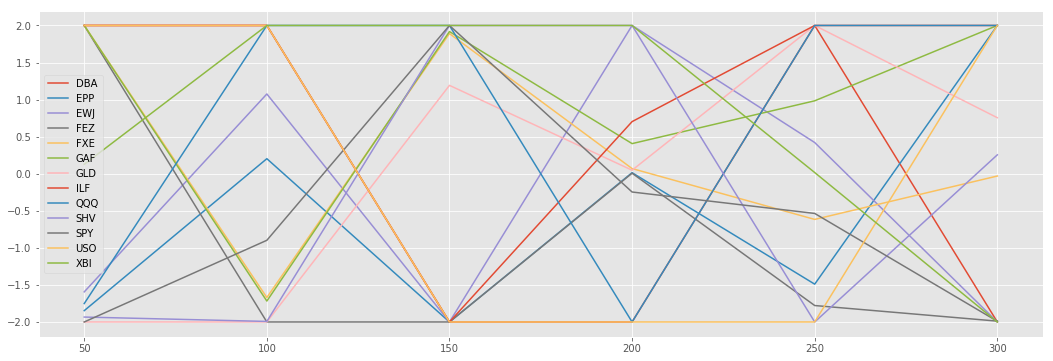

In [38]:
port_dc_short.weight_b3.plot(figsize=(18,6))

## 2.2.4 During Sub-prime crisis Long-term model

In [39]:
port_dc_long = portfolio_startegy(data_market = dc_return, data_fama = dc_fama, term = 200)

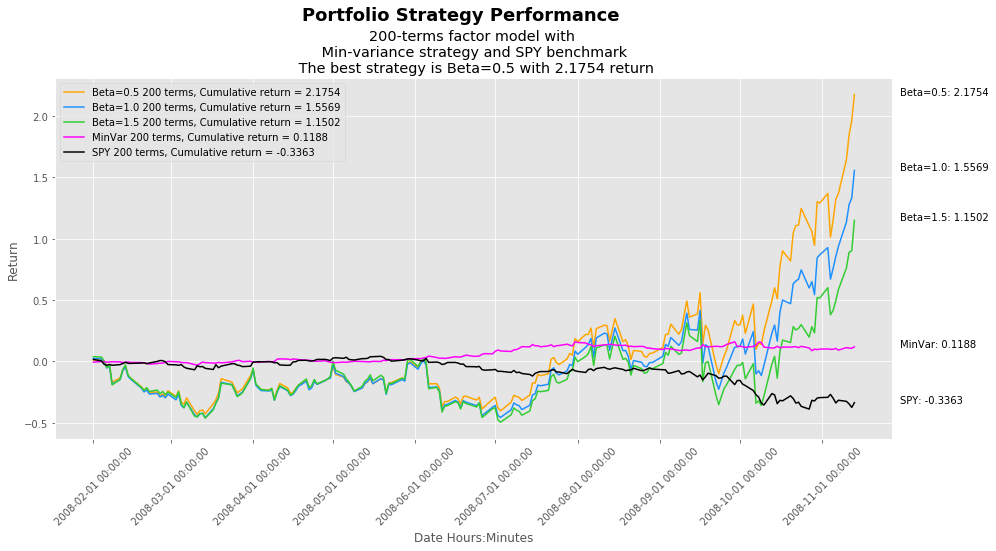

In [40]:
port_dc_long.performance_plot()

## 2.2.5 During Sub-prime crisis Risk Indicator

In [41]:
port_dc_long.risk_indicator()

,Beta=0.5,Beta=1.0,Beta=1.5,MinVar,SPY
Annual.Return,3.288096,2.263819,1.623717,0.151897,-0.403419
Daily.Mean,0.009068,0.008396,0.008489,0.000595,-0.001736
Daily.Min,-0.267172,-0.304132,-0.374699,-0.033524,-0.098448
Max10.DD,-35.718083,-57.629911,-119.365917,-3.808494,-10.464584
Volatility,0.079979,0.084515,0.094330,0.008238,0.025115
Sharpe.Ratio,0.113379,0.099344,0.089989,0.072257,-0.069119
Skewness,-0.393024,-0.467539,-0.472348,-0.063715,0.986478
Kurtosis,0.972983,1.494949,2.475844,3.092119,8.556074
Mod.VaR,-0.266868,-0.303597,-0.373785,-0.033515,-0.098048
CVaR,-0.267172,-0.304132,-0.374699,-0.033524,-0.098448


## 2.2.6  During Sub-prime crisis Short term Underlyings Analytics 

### 2.2.6.1 Beta = 0.5

In [42]:
port_dc_long.underly1

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=0.5
Annual.Return,-0.392670,-0.540468,-0.345158,-0.496796,-0.170502,-0.431491,-0.257690,-0.529142,-0.390641,0.000799,-0.403419,-0.387996,-0.032268,3.288096
Daily.Mean,-0.001701,-0.002540,-0.001282,-0.002248,-0.000704,-0.001658,-0.000965,-0.001953,-0.001665,0.000003,-0.001736,-0.001496,0.000136,0.009068
Daily.Min,-0.086060,-0.112218,-0.104077,-0.114309,-0.025717,-0.136226,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.105788,-0.069134,-0.267172
Max10.DD,-6.000100,-4.900748,-7.909109,-30.001000,-11.083119,-10.489339,-22.121154,-3.926552,-8.261937,-6.249844,-10.464584,-93.714279,-12.577020,-35.718083
Volatility,0.023407,0.033018,0.028335,0.031014,0.008674,0.034100,0.020865,0.045597,0.024534,0.000680,0.025115,0.029956,0.023206,0.079979
Sharpe.Ratio,-0.072669,-0.076912,-0.045261,-0.072481,-0.081160,-0.048626,-0.046254,-0.042830,-0.067854,0.005004,-0.069119,-0.049930,0.005876,0.113379
Skewness,-0.311663,0.626055,0.958663,1.077409,0.288442,0.332639,0.488243,0.646006,0.637260,-1.072546,0.986478,-0.103257,0.772871,-0.393024
Kurtosis,0.974582,5.608939,7.083409,8.205813,1.496846,4.738665,4.315296,7.778528,5.343745,8.049350,8.556074,0.549461,5.006287,0.972983
Mod.VaR,-0.085811,-0.112135,-0.103728,-0.114004,-0.025700,-0.135837,-0.073957,-0.193547,-0.089354,-0.003597,-0.098048,-0.105047,-0.068839,-0.266868
CVaR,-0.086060,-0.112218,-0.104077,-0.114309,-0.025717,-0.136226,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.105788,-0.069134,-0.267172


The rebalancing of Weights for beta = 0.5 during the iteration.

In [43]:
port_dc_long.weight_b1

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI
200,-2.0,-2.0,2.0,-2.0,1.139728,0.68429,-0.70608,1.435075,-0.412387,2.0,-0.175288,-0.965339,2.0


### 2.2.6.2 Beta = 1.0

In [44]:
port_dc_long.underly2

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.0
Annual.Return,-0.392670,-0.540468,-0.345158,-0.496796,-0.170502,-0.431491,-0.257690,-0.529142,-0.390641,0.000799,-0.403419,-0.387996,-0.032268,2.263819
Daily.Mean,-0.001701,-0.002540,-0.001282,-0.002248,-0.000704,-0.001658,-0.000965,-0.001953,-0.001665,0.000003,-0.001736,-0.001496,0.000136,0.008396
Daily.Min,-0.086060,-0.112218,-0.104077,-0.114309,-0.025717,-0.136226,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.105788,-0.069134,-0.304132
Max10.DD,-6.000100,-4.900748,-7.909109,-30.001000,-11.083119,-10.489339,-22.121154,-3.926552,-8.261937,-6.249844,-10.464584,-93.714279,-12.577020,-57.629911
Volatility,0.023407,0.033018,0.028335,0.031014,0.008674,0.034100,0.020865,0.045597,0.024534,0.000680,0.025115,0.029956,0.023206,0.084515
Sharpe.Ratio,-0.072669,-0.076912,-0.045261,-0.072481,-0.081160,-0.048626,-0.046254,-0.042830,-0.067854,0.005004,-0.069119,-0.049930,0.005876,0.099344
Skewness,-0.311663,0.626055,0.958663,1.077409,0.288442,0.332639,0.488243,0.646006,0.637260,-1.072546,0.986478,-0.103257,0.772871,-0.467539
Kurtosis,0.974582,5.608939,7.083409,8.205813,1.496846,4.738665,4.315296,7.778528,5.343745,8.049350,8.556074,0.549461,5.006287,1.494949
Mod.VaR,-0.085811,-0.112135,-0.103728,-0.114004,-0.025700,-0.135837,-0.073957,-0.193547,-0.089354,-0.003597,-0.098048,-0.105047,-0.068839,-0.303597
CVaR,-0.086060,-0.112218,-0.104077,-0.114309,-0.025717,-0.136226,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.105788,-0.069134,-0.304132


The rebalancing of Weights for beta = 1.0 during the iteration.

In [45]:
port_dc_long.weight_b2

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI
200,-2.0,-2.0,2.0,-1.592251,0.781245,0.654462,-0.852777,1.364049,-0.327329,2.0,-0.065565,-0.961834,2.0


### 2.2.6.3 Beta = 1.5

In [46]:
port_dc_long.underly3

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.5
Annual.Return,-0.392670,-0.540468,-0.345158,-0.496796,-0.170502,-0.431491,-0.257690,-0.529142,-0.390641,0.000799,-0.403419,-0.387996,-0.032268,1.623717
Daily.Mean,-0.001701,-0.002540,-0.001282,-0.002248,-0.000704,-0.001658,-0.000965,-0.001953,-0.001665,0.000003,-0.001736,-0.001496,0.000136,0.008489
Daily.Min,-0.086060,-0.112218,-0.104077,-0.114309,-0.025717,-0.136226,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.105788,-0.069134,-0.374699
Max10.DD,-6.000100,-4.900748,-7.909109,-30.001000,-11.083119,-10.489339,-22.121154,-3.926552,-8.261937,-6.249844,-10.464584,-93.714279,-12.577020,-119.365917
Volatility,0.023407,0.033018,0.028335,0.031014,0.008674,0.034100,0.020865,0.045597,0.024534,0.000680,0.025115,0.029956,0.023206,0.094330
Sharpe.Ratio,-0.072669,-0.076912,-0.045261,-0.072481,-0.081160,-0.048626,-0.046254,-0.042830,-0.067854,0.005004,-0.069119,-0.049930,0.005876,0.089989
Skewness,-0.311663,0.626055,0.958663,1.077409,0.288442,0.332639,0.488243,0.646006,0.637260,-1.072546,0.986478,-0.103257,0.772871,-0.472348
Kurtosis,0.974582,5.608939,7.083409,8.205813,1.496846,4.738665,4.315296,7.778528,5.343745,8.049350,8.556074,0.549461,5.006287,2.475844
Mod.VaR,-0.085811,-0.112135,-0.103728,-0.114004,-0.025700,-0.135837,-0.073957,-0.193547,-0.089354,-0.003597,-0.098048,-0.105047,-0.068839,-0.373785
CVaR,-0.086060,-0.112218,-0.104077,-0.114309,-0.025717,-0.136226,-0.074305,-0.194667,-0.089557,-0.003620,-0.098448,-0.105788,-0.069134,-0.374699


The rebalancing of Weights for beta = 1.5 during the iteration.

In [47]:
port_dc_long.weight_b3

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI
200,-2.0,-2.0,2.0,-2.0,1.01542,0.843906,-1.099987,1.920558,-0.471782,2.0,-0.034012,-1.174103,2.0


# 2.3 After Sub-prime crisis

## 2.3.1 After Sub-prime crisis Short-time model

In [48]:
port_ac_short = portfolio_startegy(data_market = ac_return, data_fama = ac_fama, term = 50)

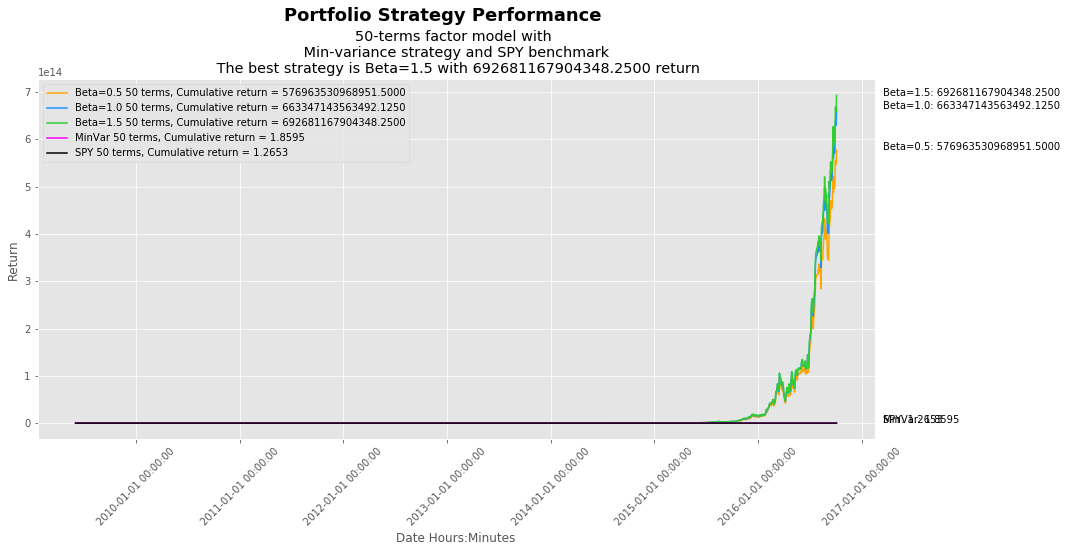

In [49]:
port_ac_short.performance_plot()

## 2.3.2 After Sub-prime crisis Short-time Risk Indicator

In [50]:
port_ac_short.risk_indicator()

,Beta=0.5,Beta=1.0,Beta=1.5,MinVar,SPY
Annual.Return,101.496203,103.462751,104.080300,0.153861,0.117823
Daily.Mean,0.020617,0.020699,0.020762,0.000595,0.000492
Daily.Min,-0.234748,-0.224417,-0.214083,-0.038517,-0.065123
Max10.DD,-0.775926,-0.865792,-0.983145,-18.970996,-18.709385
Volatility,0.065060,0.065152,0.065748,0.007367,0.009937
Sharpe.Ratio,0.316886,0.317700,0.315779,0.080793,0.049469
Skewness,0.148223,0.149602,0.136538,-0.290276,-0.360643
Kurtosis,0.816821,0.763283,0.721647,1.524019,3.433805
Mod.VaR,-0.227101,-0.219011,-0.211602,-0.037732,-0.061743
CVaR,-0.234748,-0.224417,-0.214083,-0.038517,-0.065123


## 2.3.3 After Sub-prime crisis Short term Underlyings Analytics 

### 2.3.3.1 Beta = 0.5

In [51]:
port_ac_short.underly1

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=0.5
Annual.Return,-0.047932,0.032662,0.036999,-0.013867,-0.034988,0.016787,0.032390,-0.036722,0.174297,1.358611e-04,0.117823,-0.152697,0.215016,101.496203
Daily.Mean,-0.000154,0.000227,0.000213,0.000091,-0.000123,0.000193,0.000187,-0.000011,0.000698,5.489270e-07,0.000492,-0.000459,0.000949,0.020617
Daily.Min,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081518,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.234748
Max10.DD,-60.011802,-9.650135,-25.001875,-305.939012,-49.003300,-14.062500,-8.600006,-12.249719,-67.979706,-4.084962e+11,-18.709385,-133.004367,-1.108353,-0.775926
Volatility,0.009100,0.014084,0.011702,0.017089,0.006083,0.015940,0.010940,0.016590,0.010973,1.402265e-04,0.009937,0.019924,0.018755,0.065060
Sharpe.Ratio,-0.016869,0.016112,0.018188,0.005337,-0.020190,0.012122,0.017055,-0.000647,0.063621,3.914572e-03,0.049469,-0.023018,0.050623,0.316886
Skewness,0.125476,-0.166770,-0.337494,-0.278516,-0.035366,-0.056526,-0.502322,-0.024647,-0.288005,-2.704405e-01,-0.360643,0.018482,-0.205151,0.148223
Kurtosis,2.813892,3.313257,2.773041,4.491661,1.349232,1.922779,4.294709,1.432504,2.590032,4.289888e+00,3.433805,1.793756,1.710495,0.816821
Mod.VaR,-0.045002,-0.073673,-0.068533,-0.115380,-0.026142,-0.079280,-0.081690,-0.085081,-0.058136,-9.644188e-04,-0.061743,-0.089612,-0.095834,-0.227101
CVaR,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081518,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.234748


The rebalancing of Weights for beta = 0.5 during the iteration.

In [52]:
port_ac_short.weight_b1.tail()

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI
1650,-0.239816,-1.695286,2.000000,-1.041237,2.000000,-2.000000,-2.000000,-2.000000,2.000000,2.000000,2.000000,-2.0,1.976339
1700,-0.827341,2.000000,-2.000000,-2.000000,-1.309097,2.000000,2.000000,2.000000,1.954458,-0.818021,2.000000,-2.0,-2.000000
1750,2.000000,0.528865,-0.762811,-0.917820,1.269811,1.316120,-0.441105,2.000000,-2.000000,-2.000000,0.006940,2.0,-2.000000
1800,-2.000000,0.748929,-1.126924,-2.000000,-2.000000,2.000000,2.000000,0.624961,1.740561,0.190599,0.821874,-2.0,2.000000
1850,-2.000000,-0.491358,2.000000,-0.667497,1.673603,-1.194071,-2.000000,-2.000000,1.812297,1.867027,-2.000000,2.0,2.000000


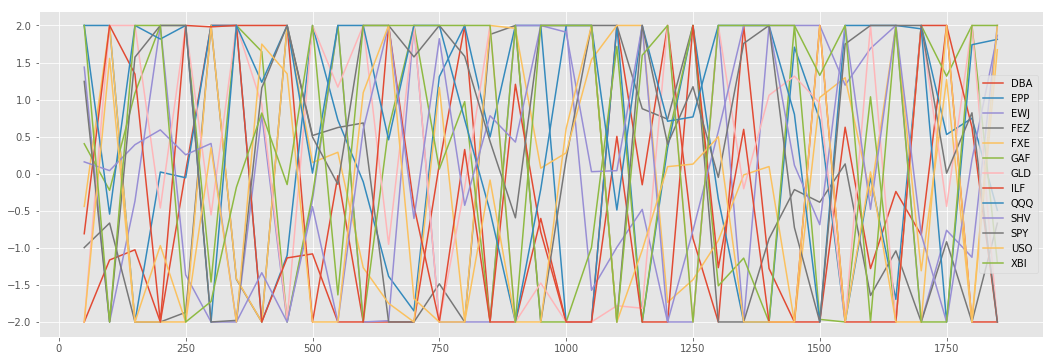

In [53]:
port_ac_short.weight_b1.plot(figsize=(18,6))

### 2.3.3.2 Beta = 1.0

In [54]:
port_ac_short.underly2

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.0
Annual.Return,-0.047932,0.032662,0.036999,-0.013867,-0.034988,0.016787,0.032390,-0.036722,0.174297,1.358611e-04,0.117823,-0.152697,0.215016,103.462751
Daily.Mean,-0.000154,0.000227,0.000213,0.000091,-0.000123,0.000193,0.000187,-0.000011,0.000698,5.489270e-07,0.000492,-0.000459,0.000949,0.020699
Daily.Min,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081518,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.224417
Max10.DD,-60.011802,-9.650135,-25.001875,-305.939012,-49.003300,-14.062500,-8.600006,-12.249719,-67.979706,-4.084962e+11,-18.709385,-133.004367,-1.108353,-0.865792
Volatility,0.009100,0.014084,0.011702,0.017089,0.006083,0.015940,0.010940,0.016590,0.010973,1.402265e-04,0.009937,0.019924,0.018755,0.065152
Sharpe.Ratio,-0.016869,0.016112,0.018188,0.005337,-0.020190,0.012122,0.017055,-0.000647,0.063621,3.914572e-03,0.049469,-0.023018,0.050623,0.317700
Skewness,0.125476,-0.166770,-0.337494,-0.278516,-0.035366,-0.056526,-0.502322,-0.024647,-0.288005,-2.704405e-01,-0.360643,0.018482,-0.205151,0.149602
Kurtosis,2.813892,3.313257,2.773041,4.491661,1.349232,1.922779,4.294709,1.432504,2.590032,4.289888e+00,3.433805,1.793756,1.710495,0.763283
Mod.VaR,-0.045002,-0.073673,-0.068533,-0.115380,-0.026142,-0.079280,-0.081690,-0.085081,-0.058136,-9.644188e-04,-0.061743,-0.089612,-0.095834,-0.219011
CVaR,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081518,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.224417


The rebalancing of Weights for beta = 1.0 during the iteration.

In [55]:
port_ac_short.weight_b2.tail()

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI
1650,-0.409972,-1.439101,2.000000,-0.870844,1.720273,-2.000000,-2.000000,-2.000000,2.000000,2.000000,1.999645,-2.0,2.0
1700,-0.936522,2.000000,-2.000000,-1.597666,-1.484905,2.000000,2.000000,2.000000,2.000000,-0.980906,2.000000,-2.0,-2.0
1750,2.000000,0.589127,-0.634366,-0.786050,1.099141,1.267670,-0.546926,2.000000,-2.000000,-2.000000,0.011403,2.0,-2.0
1800,-2.000000,0.817187,-1.015652,-2.000000,-2.000000,2.000000,2.000000,0.851663,1.673972,-0.115179,0.788010,-2.0,2.0
1850,-2.000000,-0.267554,2.000000,-0.381448,2.000000,-1.052801,-2.000000,-2.000000,1.585168,1.116635,-2.000000,2.0,2.0


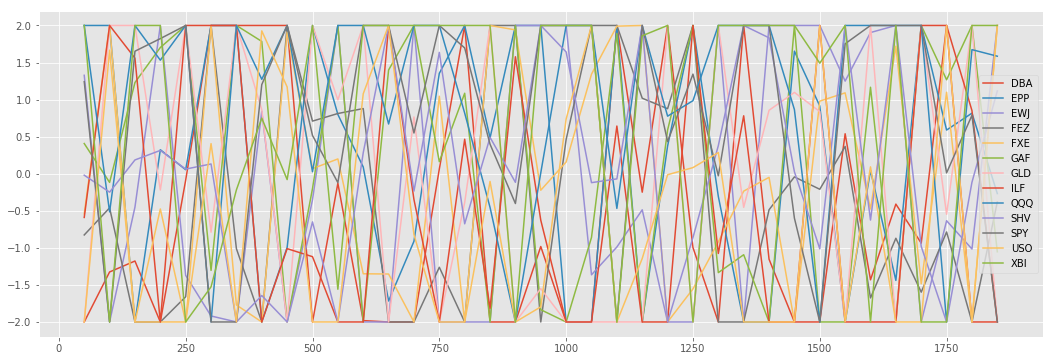

In [56]:
port_ac_short.weight_b2.plot(figsize=(18,6))

### 2.3.3.3 Beta = 1.5

In [57]:
port_ac_short.underly3

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.5
Annual.Return,-0.047932,0.032662,0.036999,-0.013867,-0.034988,0.016787,0.032390,-0.036722,0.174297,1.358611e-04,0.117823,-0.152697,0.215016,104.080300
Daily.Mean,-0.000154,0.000227,0.000213,0.000091,-0.000123,0.000193,0.000187,-0.000011,0.000698,5.489270e-07,0.000492,-0.000459,0.000949,0.020762
Daily.Min,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081518,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.214083
Max10.DD,-60.011802,-9.650135,-25.001875,-305.939012,-49.003300,-14.062500,-8.600006,-12.249719,-67.979706,-4.084962e+11,-18.709385,-133.004367,-1.108353,-0.983145
Volatility,0.009100,0.014084,0.011702,0.017089,0.006083,0.015940,0.010940,0.016590,0.010973,1.402265e-04,0.009937,0.019924,0.018755,0.065748
Sharpe.Ratio,-0.016869,0.016112,0.018188,0.005337,-0.020190,0.012122,0.017055,-0.000647,0.063621,3.914572e-03,0.049469,-0.023018,0.050623,0.315779
Skewness,0.125476,-0.166770,-0.337494,-0.278516,-0.035366,-0.056526,-0.502322,-0.024647,-0.288005,-2.704405e-01,-0.360643,0.018482,-0.205151,0.136538
Kurtosis,2.813892,3.313257,2.773041,4.491661,1.349232,1.922779,4.294709,1.432504,2.590032,4.289888e+00,3.433805,1.793756,1.710495,0.721647
Mod.VaR,-0.045002,-0.073673,-0.068533,-0.115380,-0.026142,-0.079280,-0.081690,-0.085081,-0.058136,-9.644188e-04,-0.061743,-0.089612,-0.095834,-0.211602
CVaR,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081518,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.214083


The rebalancing of Weight changes for beta = 1.5 during the iteration.

In [58]:
port_ac_short.weight_b3.tail()

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI
1650,-0.480458,-1.187157,2.000000,-0.691385,1.359000,-2.000000,-2.000000,-2.000000,2.000000,2.000000,2.000000,-2.0,2.0
1700,-1.056368,2.000000,-1.833541,-1.298708,-1.665893,2.000000,2.000000,2.000000,2.000000,-1.145491,2.000000,-2.0,-2.0
1750,2.000000,0.649616,-0.506337,-0.653960,0.928057,1.220634,-0.652607,2.000000,-2.000000,-2.000000,0.014598,2.0,-2.0
1800,-2.000000,0.885566,-0.904033,-2.000000,-2.000000,2.000000,2.000000,1.078291,1.607249,-0.421017,0.753944,-2.0,2.0
1850,-2.000000,-0.133791,2.000000,-0.222014,2.000000,-1.034044,-2.000000,-1.934058,1.587197,0.736710,-2.000000,2.0,2.0


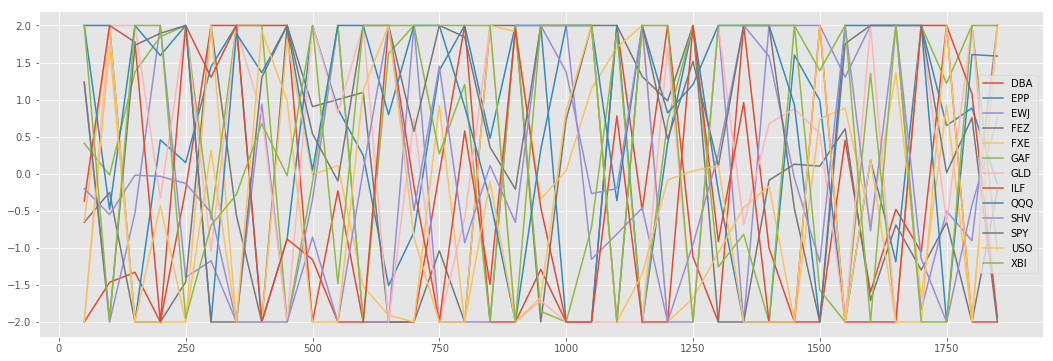

In [59]:
port_ac_short.weight_b3.plot(figsize=(18,6))

## 2.3.4 After Sub-prime crisis Long-term model

In [60]:
port_ac_long = portfolio_startegy(data_market = ac_return, data_fama = ac_fama, term = 200)

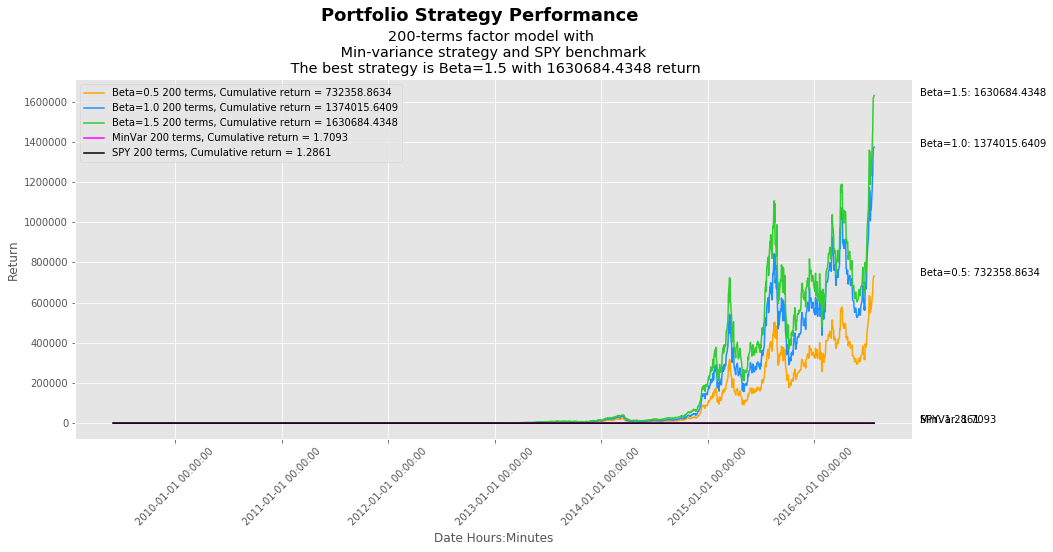

In [61]:
port_ac_long.performance_plot()

## 2.3.5 After Sub-prime crisis Long-term Risk Indicator

In [62]:
port_ac_long.risk_indicator()

,Beta=0.5,Beta=1.0,Beta=1.5,MinVar,SPY
Annual.Return,5.623102,6.233007,6.408526,0.149743,0.122722
Daily.Mean,0.009453,0.009948,0.010048,0.000595,0.000510
Daily.Min,-0.235660,-0.248286,-0.273174,-0.033764,-0.065123
Max10.DD,-0.815438,-0.873970,-1.021567,-129.366984,-18.709385
Volatility,0.061988,0.064223,0.064250,0.009094,0.010019
Sharpe.Ratio,0.152497,0.154895,0.156387,0.065456,0.050877
Skewness,-0.067859,-0.085586,-0.113828,-0.125790,-0.358718
Kurtosis,1.326226,1.195697,1.176803,1.454256,3.372999
Mod.VaR,-0.233360,-0.246426,-0.267187,-0.033637,-0.061834
CVaR,-0.235660,-0.248286,-0.273174,-0.033764,-0.065123


## 2.3.6 After Sub-prime crisis Long-term Underlyings Analytics

### 2.3.6.1 Beta = 0.5

In [63]:
port_ac_long.underly1

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=0.5
Annual.Return,-0.044862,0.029932,0.030759,-0.018353,-0.038312,0.017925,0.038601,-0.041563,0.172864,2.030714e-04,0.122722,-0.167212,0.204875,5.623102
Daily.Mean,-0.000140,0.000218,0.000190,0.000076,-0.000136,0.000199,0.000211,-0.000030,0.000694,8.152447e-07,0.000510,-0.000529,0.000917,0.009453
Daily.Min,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081518,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.235660
Max10.DD,-60.011802,-9.650135,-25.001875,-305.939012,-49.003300,-14.062500,-8.600006,-12.249719,-67.979706,-4.084962e+11,-18.709385,-133.004367,-1.108353,-0.815438
Volatility,0.009172,0.014202,0.011772,0.017252,0.006132,0.016017,0.011005,0.016611,0.011067,1.377464e-04,0.010019,0.019834,0.018786,0.061988
Sharpe.Ratio,-0.015272,0.015356,0.016116,0.004401,-0.022210,0.012419,0.019182,-0.001829,0.062735,5.918448e-03,0.050877,-0.026666,0.048798,0.152497
Skewness,0.121475,-0.160605,-0.342738,-0.272790,-0.032334,-0.062019,-0.497532,-0.008137,-0.283586,-2.350540e-01,-0.358718,0.015633,-0.198909,-0.067859
Kurtosis,2.775996,3.254540,2.755787,4.404074,1.313183,1.908317,4.254725,1.447149,2.527796,4.349110e+00,3.372999,1.909254,1.749189,1.326226
Mod.VaR,-0.045022,-0.073695,-0.068581,-0.115562,-0.026163,-0.079340,-0.081855,-0.085197,-0.058192,-9.653270e-04,-0.061834,-0.089652,-0.095974,-0.233360
CVaR,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081518,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.235660


The rebalancing of Weights for beta = 0.5 during the iteration.

In [64]:
port_ac_long.weight_b1

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI
200,-2.000000,0.927423,-0.175313,-2.000000,-1.218397,0.874165,1.235526,0.032093,2.000000,0.458728,0.865775,-2.000000,2.000000
400,2.000000,0.746213,-0.595309,-2.000000,-1.707750,2.000000,2.000000,1.083216,1.433683,-1.934054,0.077122,-1.856587,-0.246534
600,-0.340990,0.211969,-1.335143,0.851763,0.446278,-2.000000,2.000000,-2.000000,2.000000,-1.184521,1.044050,-0.693405,2.000000
800,-0.063151,0.057629,-1.248306,-2.000000,-2.000000,0.681359,-0.345019,-0.786159,2.000000,0.770176,2.000000,-0.066531,2.000000
1000,-1.793975,1.058317,2.000000,0.300599,2.000000,-2.000000,-2.000000,-2.000000,-0.031296,2.000000,1.331234,-1.461034,1.596154
1200,1.472160,-2.000000,-2.000000,1.664005,0.570467,-0.735512,-1.006160,-2.000000,2.000000,-0.735592,1.084577,0.686053,2.000000
1400,0.483610,-1.250956,-0.244819,-2.000000,0.510065,-1.363195,1.246703,-1.643246,2.000000,2.000000,1.261838,-2.000000,2.000000
1600,-2.000000,-1.044539,2.000000,0.014721,0.050333,-0.615643,1.017817,-2.000000,1.531878,1.730752,0.314681,-2.000000,2.000000
1800,-0.793789,0.515164,-0.522416,-2.000000,-0.887690,-0.258347,2.000000,1.621520,1.505113,-0.355865,1.192989,-2.000000,0.983321


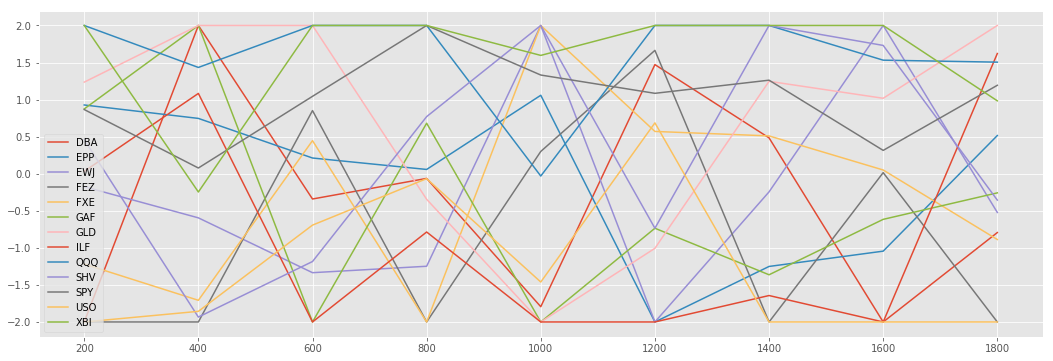

In [65]:
port_ac_long.weight_b1.plot(figsize=(18,6))

### 2.3.6.2 Beta = 1.0

In [66]:
port_ac_long.underly2

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.0
Annual.Return,-0.044862,0.029932,0.030759,-0.018353,-0.038312,0.017925,0.038601,-0.041563,0.172864,2.030714e-04,0.122722,-0.167212,0.204875,6.233007
Daily.Mean,-0.000140,0.000218,0.000190,0.000076,-0.000136,0.000199,0.000211,-0.000030,0.000694,8.152447e-07,0.000510,-0.000529,0.000917,0.009948
Daily.Min,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081518,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.248286
Max10.DD,-60.011802,-9.650135,-25.001875,-305.939012,-49.003300,-14.062500,-8.600006,-12.249719,-67.979706,-4.084962e+11,-18.709385,-133.004367,-1.108353,-0.873970
Volatility,0.009172,0.014202,0.011772,0.017252,0.006132,0.016017,0.011005,0.016611,0.011067,1.377464e-04,0.010019,0.019834,0.018786,0.064223
Sharpe.Ratio,-0.015272,0.015356,0.016116,0.004401,-0.022210,0.012419,0.019182,-0.001829,0.062735,5.918448e-03,0.050877,-0.026666,0.048798,0.154895
Skewness,0.121475,-0.160605,-0.342738,-0.272790,-0.032334,-0.062019,-0.497532,-0.008137,-0.283586,-2.350540e-01,-0.358718,0.015633,-0.198909,-0.085586
Kurtosis,2.775996,3.254540,2.755787,4.404074,1.313183,1.908317,4.254725,1.447149,2.527796,4.349110e+00,3.372999,1.909254,1.749189,1.195697
Mod.VaR,-0.045022,-0.073695,-0.068581,-0.115562,-0.026163,-0.079340,-0.081855,-0.085197,-0.058192,-9.653270e-04,-0.061834,-0.089652,-0.095974,-0.246426
CVaR,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081518,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.248286


The rebalancing of Weights for beta = 1.0 during the iteration.

In [67]:
port_ac_long.weight_b2

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI
200,-2.000000,1.068758,-0.237231,-2.000000,-1.405740,0.973803,1.206280,0.185918,2.000000,0.273487,0.934725,-2.000000,2.000000
400,2.000000,0.931674,-0.656743,-2.000000,-2.000000,2.000000,1.883667,1.287277,1.644658,-2.000000,0.136153,-2.000000,-0.226685
600,-0.432048,0.345020,-1.364350,1.066212,0.342358,-2.000000,2.000000,-2.000000,2.000000,-1.413100,1.145720,-0.689813,2.000000
800,-0.183443,0.187885,-1.221749,-2.000000,-2.000000,0.788638,-0.451112,-0.628806,2.000000,0.546080,2.000000,-0.037494,2.000000
1000,-2.000000,1.164525,2.000000,0.562441,1.983476,-2.000000,-2.000000,-2.000000,-0.150757,1.918729,1.552877,-2.000000,1.968710
1200,2.000000,-2.000000,-2.000000,2.000000,0.659628,-1.116676,-1.705987,-2.000000,2.000000,-1.304518,1.573343,0.894210,2.000000
1400,0.361538,-1.589886,-0.120528,-2.000000,0.293768,-1.412720,1.240854,-1.773025,2.000000,2.000000,2.000000,-2.000000,2.000000
1600,-2.000000,-0.907400,2.000000,0.120211,-0.075430,-0.521100,0.849429,-2.000000,1.589913,1.543224,0.401154,-2.000000,2.000000
1800,-1.053863,0.614955,-0.937314,-2.000000,-1.109023,-0.552004,2.000000,2.000000,2.000000,-0.347243,1.640516,-2.000000,0.743977


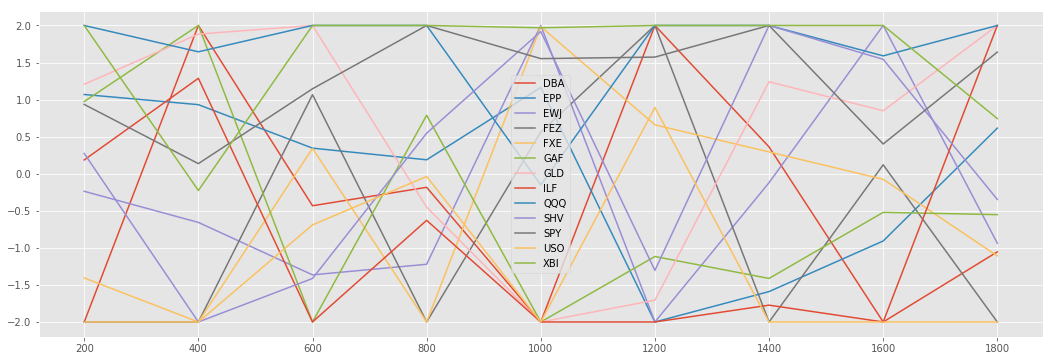

In [68]:
port_ac_long.weight_b2.plot(figsize=(18,6))

### 2.3.6.3 Beta = 1.5

In [69]:
port_ac_long.underly3

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI,Beta=1.5
Annual.Return,-0.044862,0.029932,0.030759,-0.018353,-0.038312,0.017925,0.038601,-0.041563,0.172864,2.030714e-04,0.122722,-0.167212,0.204875,6.408526
Daily.Mean,-0.000140,0.000218,0.000190,0.000076,-0.000136,0.000199,0.000211,-0.000030,0.000694,8.152447e-07,0.000510,-0.000529,0.000917,0.010048
Daily.Min,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081518,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.273174
Max10.DD,-60.011802,-9.650135,-25.001875,-305.939012,-49.003300,-14.062500,-8.600006,-12.249719,-67.979706,-4.084962e+11,-18.709385,-133.004367,-1.108353,-1.021567
Volatility,0.009172,0.014202,0.011772,0.017252,0.006132,0.016017,0.011005,0.016611,0.011067,1.377464e-04,0.010019,0.019834,0.018786,0.064250
Sharpe.Ratio,-0.015272,0.015356,0.016116,0.004401,-0.022210,0.012419,0.019182,-0.001829,0.062735,5.918448e-03,0.050877,-0.026666,0.048798,0.156387
Skewness,0.121475,-0.160605,-0.342738,-0.272790,-0.032334,-0.062019,-0.497532,-0.008137,-0.283586,-2.350540e-01,-0.358718,0.015633,-0.198909,-0.113828
Kurtosis,2.775996,3.254540,2.755787,4.404074,1.313183,1.908317,4.254725,1.447149,2.527796,4.349110e+00,3.372999,1.909254,1.749189,1.176803
Mod.VaR,-0.045022,-0.073695,-0.068581,-0.115562,-0.026163,-0.079340,-0.081855,-0.085197,-0.058192,-9.653270e-04,-0.061834,-0.089652,-0.095974,-0.267187
CVaR,-0.045724,-0.074471,-0.070305,-0.122117,-0.026927,-0.081518,-0.087808,-0.089385,-0.060190,-9.980040e-04,-0.065123,-0.091077,-0.101012,-0.273174


The rebalancing of Weights for beta = 1.0 during the iteration.

In [70]:
port_ac_long.weight_b3

,DBA,EPP,EWJ,FEZ,FXE,GAF,GLD,ILF,QQQ,SHV,SPY,USO,XBI
200,-2.000000,1.210104,-0.299016,-2.000000,-1.593255,1.073256,1.176897,0.339595,2.000000,0.088281,1.004139,-2.000000,2.000000
400,2.000000,1.544279,-1.631312,-2.000000,-2.000000,2.000000,2.000000,1.799125,1.937277,-1.969808,-0.082159,-2.000000,-0.597402
600,-0.522606,0.470231,-1.410785,1.292697,0.254756,-2.000000,2.000000,-2.000000,2.000000,-1.644302,1.256961,-0.696951,2.000000
800,-0.303704,0.318056,-1.195170,-2.000000,-2.000000,0.895848,-0.557166,-0.471435,2.000000,0.321880,2.000000,-0.008309,2.000000
1000,-2.000000,1.067514,2.000000,0.745770,1.560828,-2.000000,-2.000000,-2.000000,0.104239,1.757930,1.402361,-1.407344,1.768703
1200,2.000000,-2.000000,-2.000000,2.000000,0.690801,-1.113329,-2.000000,-2.000000,2.000000,-1.641303,2.000000,1.063831,2.000000
1400,0.209131,-1.063307,-0.120122,-2.000000,0.175801,-0.997509,0.783858,-1.249056,2.000000,2.000000,1.261205,-2.000000,2.000000
1600,-2.000000,-0.775017,2.000000,0.240691,-0.200363,-0.400161,0.680138,-2.000000,1.620256,1.352073,0.482383,-2.000000,2.000000
1800,-1.034309,0.600599,-0.588562,-2.000000,-1.190298,-0.250409,2.000000,1.934722,1.693637,-0.584608,1.340132,-2.000000,1.079097


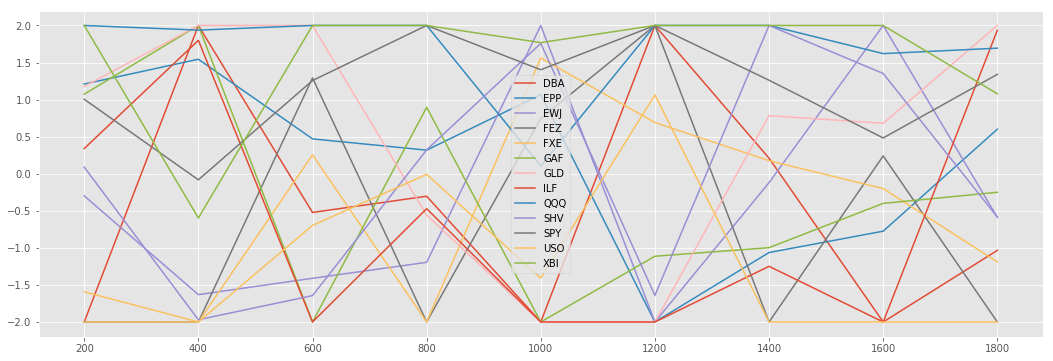

In [71]:
port_ac_long.weight_b3.plot(figsize=(18,6))

# 3. Conclusion

- $\beta = 1.5$ outperforms all periods except during the sub-prime crisis but $\beta = 0.5$ instead outperforms during the sub-prime crisis. This means that during the crisis, performing strategy less volatile than benchmark is a better choice. On the other hand, performing strategy more volatile than benchmark is better for all periods except crisis time. 
- Before crisis, as we can see, the results of strategy are more stable. This means that we will make and lose profit lower than the other periods.
- In the time of crisis, this doesn't mean we cannot make a lot of profit. As we can see that when we rebalance more frequently during the crisis to long and short correctly, we can make the heighest profit at that time. However, if we don't perform the strategy correctly, we will gain the least profit.
- After the crisis, the markets seem to recover. When we perform the strategy correctly, we can make higher profit than before the crisis but if not, we will make profit lower.